In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import *
from sklearn import metrics
import codecs
import re

# from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram

In [143]:
random_state = 42

Run the following code below to use custom python modules the team has created. 

In [144]:
import os
import sys

# directory_path = os.path.abspath(os.path.join(".."))
# if directory_path not in sys.path:
#    sys.path.append("../functions/")

# import feature_engineering

In [145]:
# from functions import feature_engineering

In [146]:
audio_path, artists_path, playlists_path = (
    r"../../data/spotify_audio_features.json",
    r"../../data/spotify_artists.json",
    r"../../data/spotify_top_50_playlists.json",
)

In [147]:
def add_features(audio_features: pd.DataFrame, artists: pd.DataFrame, playlists: pd.DataFrame) -> list:
    """add features to read in spotify data

    Args:
        audio_features (pd.DataFrame): audio features
        artists (pd.DataFrame): artists
        playlists (pd.DataFrame): playlists
    Returns:
        audio_features (pd.DataFrame): audio features w/ added features
        artists (pd.DataFrame): artists w/ added features
        playlists (pd.DataFrame): playlists w/ added features
    """
    # --- playlists --- #
    # add market ID to playlists
    playlists["market_id"] = (
        playlists["playlist_name"]
        .apply(lambda x: re.sub(r"Top Songs - ", "", x))
        .apply(lambda x: re.sub(r"\s+", "_", x).lower())
    )

    # add # of available markets by counting ","
    # it is a list column so we need to make it a string first
    playlists["num_avail_markets"] = playlists["available_markets"].apply(lambda x: len(str(x).split(",")))

    # count # of artists per song
    playlists["num_artists"] = playlists["artist_ids"].apply(lambda x: sum(1 for item in x if "id" in item))

    # create rank variable, which is row number grouped by market_id
    playlists["playlist_rank"] = playlists.groupby("market_id").cumcount() + 1

    # drop some columns
    playlists.drop(columns=["available_markets", "playlist_name"], inplace=True)

    # rename some columns
    playlists.rename(columns={"popularity": "track_popularity"}, inplace=True)

    # -- artists -- #
    artists.rename(columns={"popularity": "artist_popularity"}, inplace=True)

    return audio_features, artists, playlists


def get_data(audio_path: str, artists_path: str, playlists_path: str) -> list:
    """
    read in raw spotify api json data from local files.

    Args:
        audio_path (str): path to audio features json
        artists_path (str): path to artists json
        playlists_path (str): path to playlists json

    Returns:
        audio_features (pd.DataFrame): audio features
        artists (pd.DataFrame): artists
        playlists (pd.DataFrame): playlists
    """
    # audio features
    # with open(audio_path) as f:
    audio_features = pd.read_json(codecs.open(audio_path, "r", "utf-8"))

    # artists
    # with open(artists_path) as f:
    artists = pd.read_json(codecs.open(artists_path, "r", "utf-8"))

    # playlists
    # with open(playlists_path) as f:
    playlists = pd.read_json(codecs.open(playlists_path, "r", "utf-8"))

    # return list
    return add_features(audio_features, artists, playlists)

In [148]:
audio_df, artist_df, playlist_df = get_data(audio_path, artists_path, playlists_path)

In [149]:
display(audio_df.head())
display(artist_df.head())
display(playlist_df.head())

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7r8FHPasw67Nl4Hqyd4685,0.638,0.716,6,-7.287,0,0.0696,0.160,0.00000,0.3660,0.833,150.124,157600,4
1,2RLdkXSaiQjRbey5pvP8Kt,0.401,0.394,1,-6.655,1,0.0324,0.748,0.00000,0.0993,0.327,129.740,274387,4
2,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8,-5.549,0,0.0425,0.437,0.00000,0.1580,0.889,94.039,190005,4
3,7bFFUPBiF15n8m8RziqS4o,0.581,0.558,5,-10.404,1,0.0432,0.627,0.00022,0.1020,0.271,76.992,281494,4
4,0uHbsPVRr12ERCABBWVbe0,0.587,0.810,9,-3.519,0,0.0962,0.161,0.00000,0.1210,0.424,157.863,184488,4


,artist_id,artist_name,followers,genres,artist_popularity
0,1Kjs5u8GQf6zCFdTj6SI9E,Malik Montana,1038436,"[polish drill, polish hip hop, polish trap]",64
1,2CKOmarVWvWqkNWUatHCex,Ana Castela,2932225,"[agronejo, funk rj, sertanejo pop]",82
2,7krakxeyEmge6pzTthKNyg,Bausa,8035,[russelater],52
3,66RfYVdftqnuHRicyClgL0,Dharius,2313917,[mexican hip hop],69
4,29zSTMejPhY0m7kwNQ9SPI,Lola Amour,709383,[opm],67


,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
0,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbNG2KDcFcKOF,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,global,183,1,1
1,7x9aauaA9cu6tyfpHnqDLo,Seven (feat. Latto) (Explicit Ver.),37i9dQZEVXbNG2KDcFcKOF,single,53985D8g3JcGBoULSOYYKX,"[{'id': '6HaGTQPmzraVmaVxvz6EUc'}, {'id': '3Md...",True,97,global,184,2,2
2,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,37i9dQZEVXbNG2KDcFcKOF,album,1NAmidJlEaVgA3MpcPFYGq,[{'id': '06HL4z0CvFAxyc27GXpf02'}],False,98,global,184,1,3
3,1kuGVB7EU95pJObxwvfwKS,vampire,37i9dQZEVXbNG2KDcFcKOF,album,1xJHno7SmdVtZAtXbdbDZp,[{'id': '1McMsnEElThX1knmY4oliG'}],True,93,global,183,1,4
4,5RqSsdzTNPX1uzkmlHCFvK,QLONA,37i9dQZEVXbNG2KDcFcKOF,album,0FqAaUEyKCyUNFE1uQPZ7i,"[{'id': '790FomKkXshlbRYZFtlgla'}, {'id': '12G...",True,91,global,182,2,5


In [150]:
display(audio_df.info(), artist_df.info(), playlist_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1680 non-null   object 
 1   danceability      1680 non-null   float64
 2   energy            1680 non-null   float64
 3   key               1680 non-null   int64  
 4   loudness          1680 non-null   float64
 5   mode              1680 non-null   int64  
 6   speechiness       1680 non-null   float64
 7   acousticness      1680 non-null   float64
 8   instrumentalness  1680 non-null   float64
 9   liveness          1680 non-null   float64
 10  valence           1680 non-null   float64
 11  tempo             1680 non-null   float64
 12  duration_ms       1680 non-null   int64  
 13  time_signature    1680 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 183.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Dat

None

None

None

In [151]:
# df_join = audio_df.merge(playlist_df, on="track_id")
# df_join.info()

In [152]:
# df_join.head()

Let's create a dataframe merging the playlist tracks for each country and track statistics from spotify.

In [153]:
def create_merged_df(df1: pd.DataFrame, df2: pd.DataFrame, merged_feature: str = "track_id"):
    merged_df = df1.merge(df2, on=merged_feature)

    return merged_df

In [257]:
df_join = create_merged_df(audio_df, playlist_df)
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2899 non-null   object 
 1   danceability       2899 non-null   float64
 2   energy             2899 non-null   float64
 3   key                2899 non-null   int64  
 4   loudness           2899 non-null   float64
 5   mode               2899 non-null   int64  
 6   speechiness        2899 non-null   float64
 7   acousticness       2899 non-null   float64
 8   instrumentalness   2899 non-null   float64
 9   liveness           2899 non-null   float64
 10  valence            2899 non-null   float64
 11  tempo              2899 non-null   float64
 12  duration_ms        2899 non-null   int64  
 13  time_signature     2899 non-null   int64  
 14  track_name         2899 non-null   object 
 15  playlist_id        2899 non-null   object 
 16  album_type         2899 

If we check the rows with the merged dataframe and the original playlist dataframe, we see there is a missing track (2900 rows vs 2899). The following function will look for the missing track or tracks

In [246]:
def find_missing_tracks(merged_df: pd.DataFrame, track_df: pd.DataFrame = playlist_df):
    missing_track_df = track_df[~track_df["track_id"].isin(merged_df["track_id"])].dropna()

    return missing_track_df

In [258]:
missing_tracks_df = find_missing_tracks(df_join)
missing_tracks_df

,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
1295,6O7pAOsUm3d9R37vYdQnG5,Lovebars,37i9dQZEVXbJUPkgaWZcWG,album,37uJcI0dW70M5Hbg1WearN,"[{'id': '5dXlc7MnpaTeUIsHLVe3n4'}, {'id': '7Bg...",False,68,italy,183,2,46


In order to add this missing track to our training data we need to input missing variable data. Since this information is unavailable from the source (Spotify), we will take the mean value of each measurement in each country playlist. We will assume that the missing tracks will have similar stats to other tracks in its country of origin. The function below will create a stat dataframe for the each country that we can then use to fill in missing information for the track or tracks. 

In [157]:
def create_country_stats(merged_df: pd.DataFrame, stat: str = "mean"):
    calc_df = df_join.select_dtypes(exclude=["object", "bool"])

    calc_df2 = df_join[calc_df.columns.tolist() + ["market_id"]].drop(
        ["track_popularity", "num_avail_markets", "playlist_rank", "num_artists"], axis=1
    )

    if stat == "mean":
        stat_df = calc_df2.groupby("market_id").mean().reset_index()

    elif stat == "variance" or stat == "var":
        stat_df = calc_df2.groupby("market_id").var().reset_index()

    elif stat == "std":
        stat_df = calc_df2.groupby("market_id").std().reset_index()

    elif stat == "max":
        stat_df = calc_df2.groupby("market_id").max().reset_index()

    elif stat == "min":
        stat_df = calc_df2.groupby("market_id").min().reset_index()

    elif stat == "median":
        stat_df = calc_df2.groupby("market_id").median().reset_index()

    return stat_df

In [158]:
mean_df = create_country_stats(df_join)
mean_df.head(10)

,market_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,argentina,0.71360,0.681500,6.58,-5.26474,0.56,0.099504,0.204713,0.000037,0.180834,0.629460,116.54620,180435.52,3.92
1,australia,0.63108,0.648162,5.08,-6.76162,0.76,0.081830,0.271935,0.009575,0.161508,0.530140,128.73094,199307.84,3.88
2,austria,0.68354,0.667262,5.20,-6.92660,0.54,0.108322,0.235301,0.019419,0.150992,0.481160,130.02064,171698.04,3.92
3,belarus,0.68412,0.667200,4.62,-6.71352,0.48,0.099148,0.184487,0.062134,0.207644,0.481682,128.87126,151340.04,3.96
4,belgium,0.66792,0.702742,4.96,-6.36422,0.46,0.107370,0.251751,0.023322,0.169942,0.550520,130.09938,187924.68,3.88
5,brazil,0.69118,0.738200,5.88,-4.93606,0.56,0.108008,0.371288,0.001545,0.359040,0.658960,132.43876,166263.44,4.00
6,canada,0.61534,0.593702,5.24,-6.73580,0.64,0.082652,0.347049,0.003016,0.178946,0.486540,125.32364,202735.78,3.84
7,chile,0.70890,0.691320,5.82,-6.09794,0.54,0.097294,0.225940,0.019490,0.166546,0.651180,115.62412,195849.18,3.84
8,colombia,0.76404,0.703740,4.84,-5.11196,0.36,0.123370,0.267254,0.018074,0.157500,0.593380,121.58590,187218.22,3.92
9,czech_republic,0.69150,0.666462,5.24,-7.39578,0.40,0.125426,0.226099,0.031040,0.172678,0.500400,125.90296,181331.26,3.94


In [159]:
# playlist_df[~playlist_df["track_id"].isin(df_join["track_id"])].dropna()["track_id"].values().tolist()

In [160]:
# track_df = playlist_df[~playlist_df["track_id"].isin(df_join["track_id"])].dropna()
# track_df

In [161]:
# calc_df = df_join.select_dtypes(exclude=["object", "bool"])
# calc_df2 = df_join[calc_df.columns.tolist() + ["market_id"]].drop(['track_popularity', 'num_avail_markets', 'playlist_rank', 'num_artists'], axis=1)
# mean_df = calc_df2.groupby('market_id').mode()

With the country statistics for songs we will fill in the average statistic in each category for the missing track and then add that missing track to our merged dataframe. The result should have 2900 rows. This is 50 top songs across 58 countries. 

In [162]:
def add_missing_tracks(merged_df: pd.DataFrame, missing_tracks_df: pd.DataFrame, stats_df: pd.DataFrame):
    missing_stats_df = missing_tracks_df.merge(stats_df, on="market_id")

    final_df = pd.concat([merged_df, missing_stats_df], ignore_index=True)

    return final_df

In [261]:
def add_artists(merged_df: pd.DataFrame, artist_df: pd.DataFrame):
    new_art_df = artist_df.drop("genres", axis=1)

    df2 = merged_df.copy()

    df2["artist_ids"] = df2["artist_ids"].apply(lambda x: x[0]["id"])

    df2 = df2.rename(columns={"artist_ids": "artist_id"})

    artist_merged = create_merged_df(df2, new_art_df, "artist_id")

    return artist_merged

In [259]:
df_join_final = add_missing_tracks(df_join, missing_tracks_df, mean_df)
df_join_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2900 non-null   object 
 1   danceability       2900 non-null   float64
 2   energy             2900 non-null   float64
 3   key                2900 non-null   float64
 4   loudness           2900 non-null   float64
 5   mode               2900 non-null   float64
 6   speechiness        2900 non-null   float64
 7   acousticness       2900 non-null   float64
 8   instrumentalness   2900 non-null   float64
 9   liveness           2900 non-null   float64
 10  valence            2900 non-null   float64
 11  tempo              2900 non-null   float64
 12  duration_ms        2900 non-null   float64
 13  time_signature     2900 non-null   float64
 14  track_name         2900 non-null   object 
 15  playlist_id        2900 non-null   object 
 16  album_type         2900 

In [255]:
df_join_final.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
0,7r8FHPasw67Nl4Hqyd4685,0.638,0.716,6.0,-7.287,0.0,0.0696,0.160,0.00000,0.3660,...,37i9dQZEVXbLWYFZ5CkSvr,single,5WJLZ54uK7ni636O65EztT,1Kj6Km5IuLGKt2cxuhSgLm,True,64,norway,184,1,23
1,2RLdkXSaiQjRbey5pvP8Kt,0.401,0.394,1.0,-6.655,1.0,0.0324,0.748,0.00000,0.0993,...,37i9dQZEVXbJZGli0rRP3r,album,5ITErfEiF1nEo8KTRgLv43,75MOYjGEyyH5U4ZFHOPvxR,False,59,south_korea,184,1,33
2,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.00000,0.1580,...,37i9dQZEVXbMPoK06pe7d6,single,464FQ8gr0oKlQ1a0TCK4Yj,2R21vXR83lH98kGeO99Y66,False,83,dominican_republic,180,2,43
3,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.00000,0.1580,...,37i9dQZEVXbMGcjiWgg253,single,464FQ8gr0oKlQ1a0TCK4Yj,2R21vXR83lH98kGeO99Y66,False,83,peru,180,2,41
4,7bFFUPBiF15n8m8RziqS4o,0.581,0.558,5.0,-10.404,1.0,0.0432,0.627,0.00022,0.1020,...,37i9dQZEVXbKZyn1mKjmIl,single,7q2bB2NNFlNbtqadbn55pL,6d0dLenjy5CnR5ZMn2agiV,False,63,vietnam,183,1,41


In [244]:
df_join_final["artist_ids"].unique()

array(['1Kj6Km5IuLGKt2cxuhSgLm', '75MOYjGEyyH5U4ZFHOPvxR',
       '2R21vXR83lH98kGeO99Y66', ..., '5OaC42gxOxSYgfmmSxe672',
       '1iRlPYW9AnnyLTPfy53Mj9', '2E93OTghhH2JKYUWt48gFK'], dtype=object)

In [250]:
test = df_join_final.copy()
test["artist_ids"] = test["artist_ids"].apply(lambda x: x[0]["id"])
test

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
0,7r8FHPasw67Nl4Hqyd4685,0.638000,0.716000,6.000000,-7.287000,0.00000,0.069600,0.160000,0.000000,0.366000,...,37i9dQZEVXbLWYFZ5CkSvr,single,5WJLZ54uK7ni636O65EztT,1Kj6Km5IuLGKt2cxuhSgLm,True,64,norway,184,1,23
1,2RLdkXSaiQjRbey5pvP8Kt,0.401000,0.394000,1.000000,-6.655000,1.00000,0.032400,0.748000,0.000000,0.099300,...,37i9dQZEVXbJZGli0rRP3r,album,5ITErfEiF1nEo8KTRgLv43,75MOYjGEyyH5U4ZFHOPvxR,False,59,south_korea,184,1,33
2,1LiN0Z98FkR1t0m8KmLcAH,0.790000,0.631000,8.000000,-5.549000,0.00000,0.042500,0.437000,0.000000,0.158000,...,37i9dQZEVXbMPoK06pe7d6,single,464FQ8gr0oKlQ1a0TCK4Yj,2R21vXR83lH98kGeO99Y66,False,83,dominican_republic,180,2,43
3,1LiN0Z98FkR1t0m8KmLcAH,0.790000,0.631000,8.000000,-5.549000,0.00000,0.042500,0.437000,0.000000,0.158000,...,37i9dQZEVXbMGcjiWgg253,single,464FQ8gr0oKlQ1a0TCK4Yj,2R21vXR83lH98kGeO99Y66,False,83,peru,180,2,41
4,7bFFUPBiF15n8m8RziqS4o,0.581000,0.558000,5.000000,-10.404000,1.00000,0.043200,0.627000,0.000220,0.102000,...,37i9dQZEVXbKZyn1mKjmIl,single,7q2bB2NNFlNbtqadbn55pL,6d0dLenjy5CnR5ZMn2agiV,False,63,vietnam,183,1,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0EzNyXyU7gHzj2TN8qYThj,0.718000,0.643000,4.000000,-7.473000,0.00000,0.160000,0.441000,0.000000,0.113000,...,37i9dQZEVXbKQ1ogMOyW9N,album,69njUAy8iu7QDMUYRYTQc2,0LKAV3zJ8a8AIGnyc5OvfB,True,78,france,183,1,10
2896,19IAoqAkRQ5tC1U0p7SWpZ,0.815000,0.644000,8.000000,-5.692000,1.00000,0.082000,0.350000,0.000008,0.205000,...,37i9dQZEVXbLw80jjcctV1,single,7adhYj6nGEGJots1OpYgdg,4JM1zsVj1pt38Q8mhv5teI,False,67,nigeria,183,1,19
2897,2sFMjvuXE0CxmlQLnwi5J4,0.863000,0.735000,10.000000,-4.400000,0.00000,0.259000,0.104000,0.000284,0.166000,...,37i9dQZEVXbMw2iUtFR5Eq,album,5Ng4OnFWSIHykMULfuRXn6,74HomvqoUecDcUPRespyqg,True,32,denmark,179,1,49
2898,3x2hKSUf8O8IqI1shmxGnp,0.679000,0.563000,10.000000,-7.009000,1.00000,0.033400,0.503000,0.000000,0.102000,...,37i9dQZEVXbMdvweCgpBAe,album,34BPcfbDQkYaJLrCgrEwYx,5tRk0bqMQubKAVowp35XtC,False,58,hong_kong,183,1,21


In [262]:
df_join_artist = add_artists(df_join_final, artist_df)
df_join_artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2900 non-null   object 
 1   danceability       2900 non-null   float64
 2   energy             2900 non-null   float64
 3   key                2900 non-null   float64
 4   loudness           2900 non-null   float64
 5   mode               2900 non-null   float64
 6   speechiness        2900 non-null   float64
 7   acousticness       2900 non-null   float64
 8   instrumentalness   2900 non-null   float64
 9   liveness           2900 non-null   float64
 10  valence            2900 non-null   float64
 11  tempo              2900 non-null   float64
 12  duration_ms        2900 non-null   float64
 13  time_signature     2900 non-null   float64
 14  track_name         2900 non-null   object 
 15  playlist_id        2900 non-null   object 
 16  album_type         2900 

In [263]:
df_join_artist.head(10)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artist_id,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank,artist_name,followers,artist_popularity
0,7r8FHPasw67Nl4Hqyd4685,0.638,0.716,6.0,-7.287,0.0,0.0696,0.1600,0.000000,0.3660,...,1Kj6Km5IuLGKt2cxuhSgLm,True,64,norway,184,1,23,Golfklubb,6208,55
1,0wnkw8ZMMvc9K98H6TWu1q,0.770,0.677,1.0,-6.613,1.0,0.0392,0.0162,0.000005,0.1020,...,1Kj6Km5IuLGKt2cxuhSgLm,False,62,norway,184,1,30,Golfklubb,6208,55
2,2RLdkXSaiQjRbey5pvP8Kt,0.401,0.394,1.0,-6.655,1.0,0.0324,0.7480,0.000000,0.0993,...,75MOYjGEyyH5U4ZFHOPvxR,False,59,south_korea,184,1,33,Lim Young Woong,63417,60
3,6auT8cRBu3BgPRBrdVBY15,0.520,0.875,2.0,-1.589,1.0,0.0346,0.3950,0.000000,0.5150,...,75MOYjGEyyH5U4ZFHOPvxR,False,66,south_korea,184,1,23,Lim Young Woong,63417,60
4,2jidjmWNeRmKgLjXhW52Gz,0.381,0.405,1.0,-7.325,1.0,0.0325,0.6290,0.000000,0.4180,...,75MOYjGEyyH5U4ZFHOPvxR,False,58,south_korea,184,1,46,Lim Young Woong,63417,60
5,2tA3NP12r4niSRhb9Y6AoY,0.703,0.768,0.0,-3.357,1.0,0.0289,0.5320,0.000000,0.1170,...,75MOYjGEyyH5U4ZFHOPvxR,False,64,south_korea,184,1,26,Lim Young Woong,63417,60
6,4WUpMUjdoi47LY7gBQBXe3,0.515,0.346,4.0,-8.908,1.0,0.0342,0.7760,0.000027,0.1190,...,75MOYjGEyyH5U4ZFHOPvxR,False,67,south_korea,184,1,22,Lim Young Woong,63417,60
7,50xSycnGMDy0Wg5jJcOv3S,0.641,0.889,8.0,-3.534,1.0,0.0541,0.0394,0.000000,0.1810,...,75MOYjGEyyH5U4ZFHOPvxR,False,58,south_korea,184,1,40,Lim Young Woong,63417,60
8,4Cr43xPo7bwyCcL1g3yVCu,0.606,0.729,0.0,-4.555,1.0,0.0804,0.2680,0.000000,0.2710,...,75MOYjGEyyH5U4ZFHOPvxR,False,57,south_korea,184,1,50,Lim Young Woong,63417,60
9,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8.0,-5.549,0.0,0.0425,0.4370,0.000000,0.1580,...,2R21vXR83lH98kGeO99Y66,False,83,dominican_republic,180,2,43,Anuel AA,32565139,86


In [165]:
def get_correlation_matrix(df, corr_feats):
    corr_df = df[corr_feats]
    # corr = corr_df.corr()

    # plt.figure(figsize=(18, 10))
    # sns.heatmap(corr, annot=True)

    return corr_df.corr()

In [166]:
def get_country_correlations(countries: list, corr_variables: list, merged_df: pd.DataFrame):
    country_list = np.sort(countries)
    # correlation_list = np.sort(corr_variables)
    correlation_dic = {}
    corr_var_dic = {"Rank": ["1st", "2nd"]}
    for country in country_list:
        df2 = merged_df[merged_df["market_id"] == country]
        corr_matrix = get_correlation_matrix(df2, corr_variables)
        corr_matrix = corr_matrix.reset_index()
        # rank_matrix = corr_matrix[corr_matrix["index"] == "playlist_rank"]
        dic = {corr_matrix["index"][i]: abs(corr_matrix["playlist_rank"][i]) for i in range(len(corr_matrix))}

        var1 = sorted(dic, key=dic.get)[-2]
        var2 = sorted(dic, key=dic.get)[-3]

        corr_var_dic[country] = [var1, var2]
        correlation_dic[country] = {var1: dic[var1], var2: dic[var2]}

    top_df = pd.DataFrame.from_dict(corr_var_dic)  # .reset_index().rename(columns= {"index": "rank"})
    top_variables_df = pd.melt(
        top_df,
        id_vars=["Rank"],
        ignore_index=True,
        value_vars=top_df.columns[1:],
        var_name="Country",
        value_name="Top_Variable",
    )
    top_df_final = top_variables_df.pivot_table(columns="Rank", index="Country", values="Top_Variable", aggfunc="first")

    return correlation_dic, top_df_final

In [167]:
correlation_variables = df_join_final.columns.tolist()[1:13] + ["playlist_rank"]
correlation_variables.remove("mode")
correlation_variables.remove("key")
countries = df_join_final.market_id.unique().tolist()

country_corr_values, country_variables = get_country_correlations(countries, correlation_variables, df_join_final)

In [168]:
country_variables.head(10)

Rank,1st,2nd
Country,,
argentina,danceability,speechiness
australia,instrumentalness,liveness
austria,energy,duration_ms
belarus,danceability,tempo
belgium,duration_ms,tempo
brazil,danceability,energy
canada,danceability,valence
chile,danceability,tempo
colombia,valence,duration_ms


In [169]:
# test = pd.DataFrame.from_dict(country_variables).reset_index().rename(columns= {"index": "rank"})
# top_variables_df = pd.melt(test, id_vars=None, ignore_index=True, value_vars=test.columns[1:], var_name="Country", value_name="Top_Variable")
# test.pivot_table(columns="rank", values=test.columns[1:])
# country_variables.pivot_table(index=country_variables.columns[1:], columns=["Rank"])
# test= country_variables.copy()
##test2 = pd.melt(test, id_vars=["Rank"], ignore_index=True, value_vars=test.columns[1:], var_name="Country", value_name="Top_Variable")
# test2.pivot_table(columns="Rank", index="Country", values="Top_Variable", aggfunc='first')
# top_var1 = max(country_variables["1st"].tolist(), key=country_variables["1st"].tolist().count)
# top_var2 = max(country_variables["1st"].tolist(), key=country_variables["1st"].tolist().count[1])
# top_var3 = max(country_variables["1st"].tolist(), key=country_variables["1st"].tolist().count[2])
top_var1 = country_variables["1st"].value_counts().index[0]
top_var2 = country_variables["1st"].value_counts().index[1]
top_var3 = country_variables["1st"].value_counts().index[2]
# top_var2
country_variables["1st"].value_counts()

1st
energy              12
danceability         9
valence              6
tempo                6
instrumentalness     5
duration_ms          5
liveness             5
speechiness          4
loudness             3
acousticness         3
Name: count, dtype: int64

In [170]:
country_corr_values.keys()

dict_keys(['argentina', 'australia', 'austria', 'belarus', 'belgium', 'brazil', 'canada', 'chile', 'colombia', 'czech_republic', 'denmark', 'dominican_republic', 'ecuador', 'egypt', 'finland', 'france', 'germany', 'global', 'guatemala', 'hong_kong', 'hungary', 'india', 'indonesia', 'ireland', 'israel', 'italy', 'japan', 'kazakhstan', 'malaysia', 'mexico', 'morocco', 'netherlands', 'new_zealand', 'nigeria', 'norway', 'pakistan', 'panama', 'peru', 'philippines', 'poland', 'romania', 'saudi_arabia', 'singapore', 'slovakia', 'south_africa', 'south_korea', 'spain', 'sweden', 'switzerland', 'taiwan', 'thailand', 'turkey', 'uae', 'ukraine', 'united_kingdom', 'usa', 'venezuela', 'vietnam'])

In [171]:
correlation_variables = df_join_final.columns.tolist()[1:11] + ["playlist_rank"]
# sns.heatmap(df_join_final[correlation_variables].corr())
test = get_correlation_matrix(df_join_final[df_join_final["market_id"] == "usa"], correlation_variables)

test = test.reset_index()  # .rename(columns= {test.index.name: "Variable"})
test
# {test["index"][i]: test["playlist_rank"][i] for i in range(len(test))}

,index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,playlist_rank
0,danceability,1.000000,0.295665,0.142544,0.181811,-0.187404,0.292717,-0.228992,0.053044,-0.005403,0.577714,-0.019305
1,energy,0.295665,1.000000,0.175867,0.831125,-0.104426,0.188057,-0.782220,0.115651,0.218880,0.547743,0.086480
2,key,0.142544,0.175867,1.000000,0.110832,-0.198348,-0.044108,-0.031121,0.124088,0.063664,0.172216,0.029074
3,loudness,0.181811,0.831125,0.110832,1.000000,-0.016769,0.001443,-0.695520,0.073836,0.090052,0.366109,0.044157
4,mode,-0.187404,-0.104426,-0.198348,-0.016769,1.000000,-0.102217,0.062184,0.109501,-0.050793,0.011617,-0.115564
5,speechiness,0.292717,0.188057,-0.044108,0.001443,-0.102217,1.000000,-0.238181,-0.096807,-0.000123,0.193998,0.108393
6,acousticness,-0.228992,-0.782220,-0.031121,-0.695520,0.062184,-0.238181,1.000000,-0.170189,-0.133155,-0.336021,0.082164
7,instrumentalness,0.053044,0.115651,0.124088,0.073836,0.109501,-0.096807,-0.170189,1.000000,-0.031159,-0.056140,-0.018863
8,liveness,-0.005403,0.218880,0.063664,0.090052,-0.050793,-0.000123,-0.133155,-0.031159,1.000000,0.146565,-0.100733
9,valence,0.577714,0.547743,0.172216,0.366109,0.011617,0.193998,-0.336021,-0.056140,0.146565,1.000000,0.029436


In [172]:
num_k = len(df_join_final.market_id.unique())
num_k

58

In [173]:
len(df_join_final)

2900

In [174]:
# generate number labels per market to compare with model
# hot_code_labels = np.arange(58)
# hot_code_labels

In [175]:
# sort markets by alphabetical order and create dictionary for mapping
# markets = np.sort(df_join.market_id.unique()).tolist()
# markets
# market_dic = {markets[i]: hot_code_labels[i] for i in range(len(hot_code_labels))}
# market_dic
# new column for market_label is created in dataframe
# df_join["market_label"] = df_join["market_id"].map(market_dic)
# df_join[["market_id","market_label"]].head(10)

In [176]:
def create_training_data(final_merged_df: pd.DataFrame, outcome_variable: str, excluded_features: list):
    # outcome variable is the y training label aimed for by model
    # excluded features are columns from the merged dataframe that should be dropped from training

    y_train = final_merged_df[outcome_variable].tolist()

    X_train = final_merged_df.select_dtypes(exclude=["object", "bool"])

    data_drop_cols = excluded_features

    X_train.drop(data_drop_cols, axis=1, inplace=True)

    return X_train, y_train

In [177]:
# X_train, y_train = create_training_data(df_join_final, "market_id", ["playlist_rank", "track_popularity"])

In [178]:
excluded_cols = df_join_final.columns.tolist()
for var in correlation_variables:
    excluded_cols.remove(var)
# X_train, y_train = create_training_data(df_join_final, "market_id", excluded_cols)
# excluded_cols

In [179]:
X_train = df_join_final[correlation_variables]
X_train = X_train.drop("playlist_rank", axis=1)

In [180]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      2900 non-null   float64
 1   energy            2900 non-null   float64
 2   key               2900 non-null   float64
 3   loudness          2900 non-null   float64
 4   mode              2900 non-null   float64
 5   speechiness       2900 non-null   float64
 6   acousticness      2900 non-null   float64
 7   instrumentalness  2900 non-null   float64
 8   liveness          2900 non-null   float64
 9   valence           2900 non-null   float64
dtypes: float64(10)
memory usage: 226.7 KB


In [181]:
# X = df_join.select_dtypes(exclude=["object", "bool"])

# drop columns that may be too big a factor for cluster
# data_drop_cols = ["market_label", "playlist_rank", "track_popularity"]
# X.drop(data_drop_cols, axis=1, inplace=True)
# X.info()

In [182]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_train)

In [183]:
# kmeans = KMeans(n_clusters=num_k, random_state=random_state)
# kmeans.fit(X_scaled)

In [184]:
from k_means_constrained import KMeansConstrained

kmeans = KMeansConstrained(n_clusters=58, size_min=50, size_max=50, random_state=random_state)
kmeans.fit(X_scaled)

KMeansConstrained(copy_x=True, init='k-means++', max_iter=300, n_clusters=58,
         n_init=10, n_jobs=1, random_state=42, size_max=50, size_min=50,
         tol=0.0001, verbose=False)

In [185]:
# kmeans.cluster_centers_.shape

df_join_final["cluster"] = kmeans.labels_
# df_join["centroid"] = kmeans.cluster_centers_
df_join_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2900 non-null   object 
 1   danceability       2900 non-null   float64
 2   energy             2900 non-null   float64
 3   key                2900 non-null   float64
 4   loudness           2900 non-null   float64
 5   mode               2900 non-null   float64
 6   speechiness        2900 non-null   float64
 7   acousticness       2900 non-null   float64
 8   instrumentalness   2900 non-null   float64
 9   liveness           2900 non-null   float64
 10  valence            2900 non-null   float64
 11  tempo              2900 non-null   float64
 12  duration_ms        2900 non-null   float64
 13  time_signature     2900 non-null   float64
 14  track_name         2900 non-null   object 
 15  playlist_id        2900 non-null   object 
 16  album_type         2900 

In [186]:
import matplotlib.pyplot as plt

In [187]:
def plot_features(df: pd.DataFrame, feature: str, features: list, label: str):
    # features are a list of features from the data to be compared in plots.

    plot_feats = [f for f in features if f != feature]

    fig, axs = plt.subplots(1, len(plot_feats), sharey=True)

    for feat, ax in zip(plot_feats, axs.ravel()):
        ax.scatter(df[feat], df[feature], c=df[label])

    return plt.show()

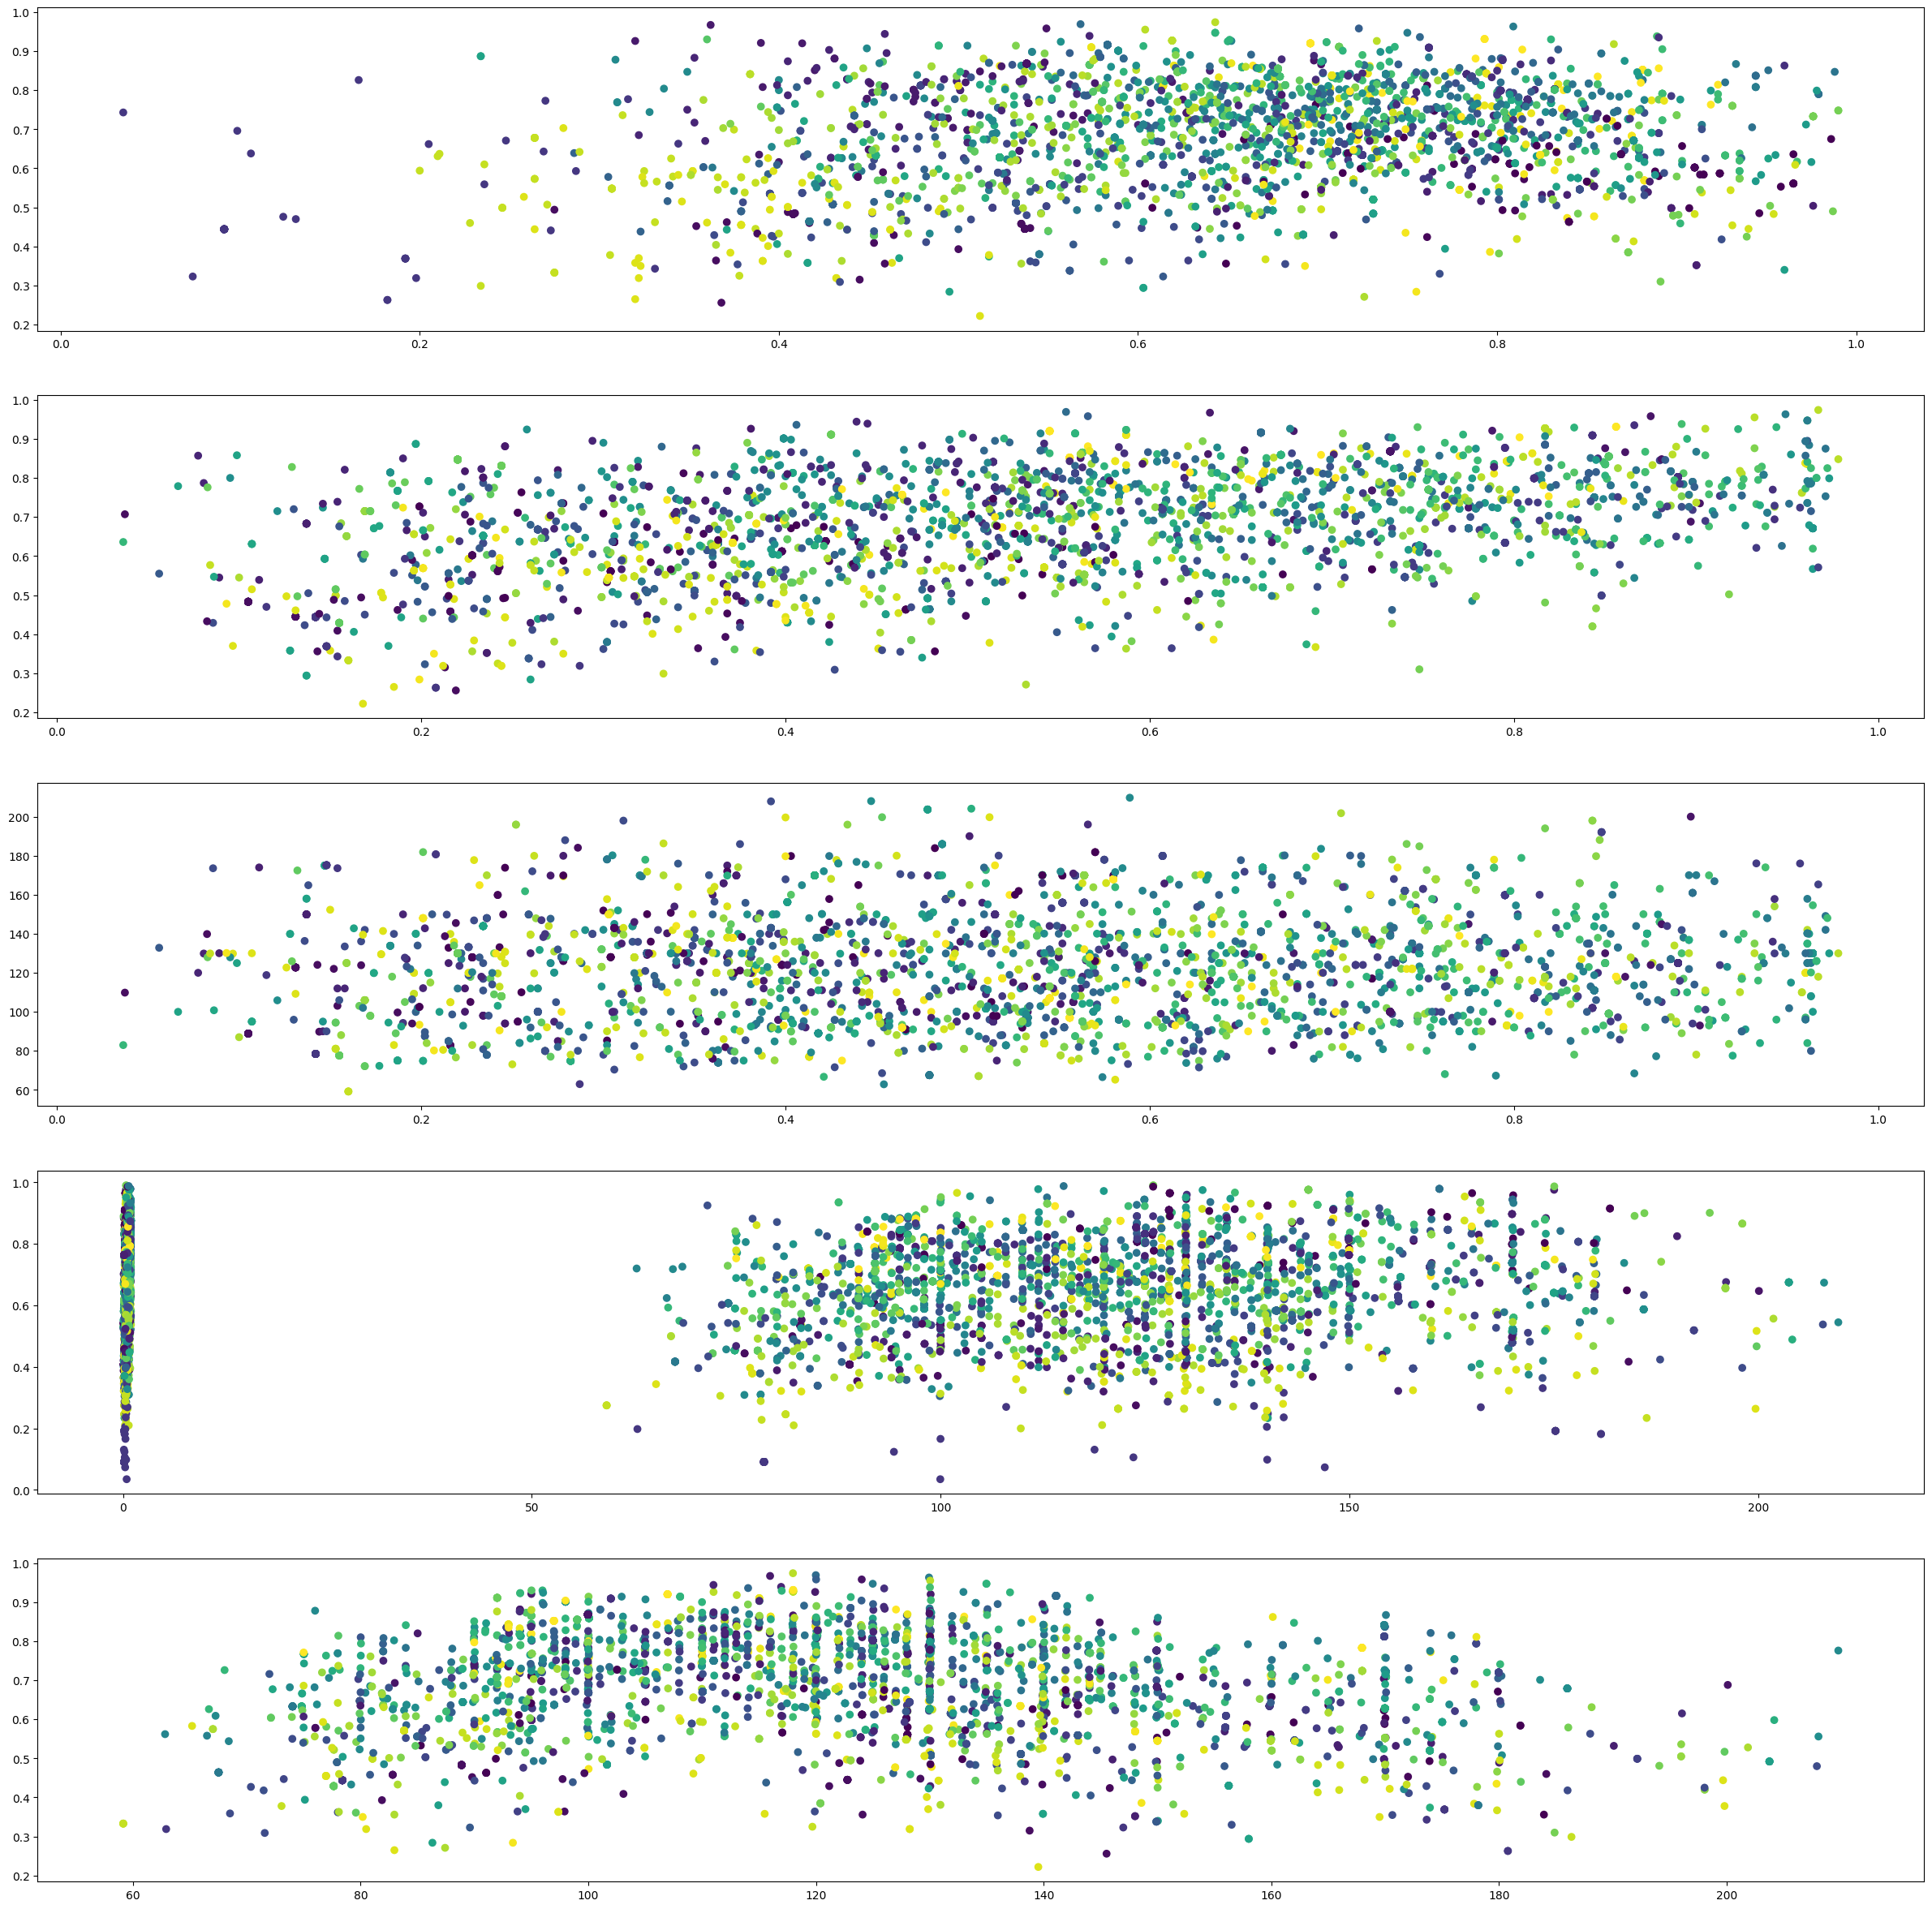

In [188]:
fig, axs = plt.subplots(5, 1, figsize=(30, 30))

axs[0].scatter(df_join_final["energy"], df_join_final["danceability"], c=df_join_final["cluster"])
axs[1].scatter(df_join_final["valence"], df_join_final["danceability"], c=df_join_final["cluster"])
axs[2].scatter(df_join_final["valence"], df_join_final["tempo"], c=df_join_final["cluster"])
axs[3].scatter(df_join_final["tempo"], df_join_final["energy"], c=df_join_final["cluster"])
axs[4].scatter(df_join_final["tempo"], df_join_final["danceability"], c=df_join_final["cluster"])
axs[3].scatter(df_join_final["valence"], df_join_final["energy"], c=df_join_final["cluster"])

In [189]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# pca.fit(X_scaled)

pca_plot_data = pd.DataFrame(pca.fit_transform(X_scaled), columns=["PC1", "PC2"])

pca_plot_data["cluster"] = pd.Categorical(kmeans.labels_)
pca_plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   PC1      2900 non-null   float64 
 1   PC2      2900 non-null   float64 
 2   cluster  2900 non-null   category
dtypes: category(1), float64(2)
memory usage: 50.1 KB


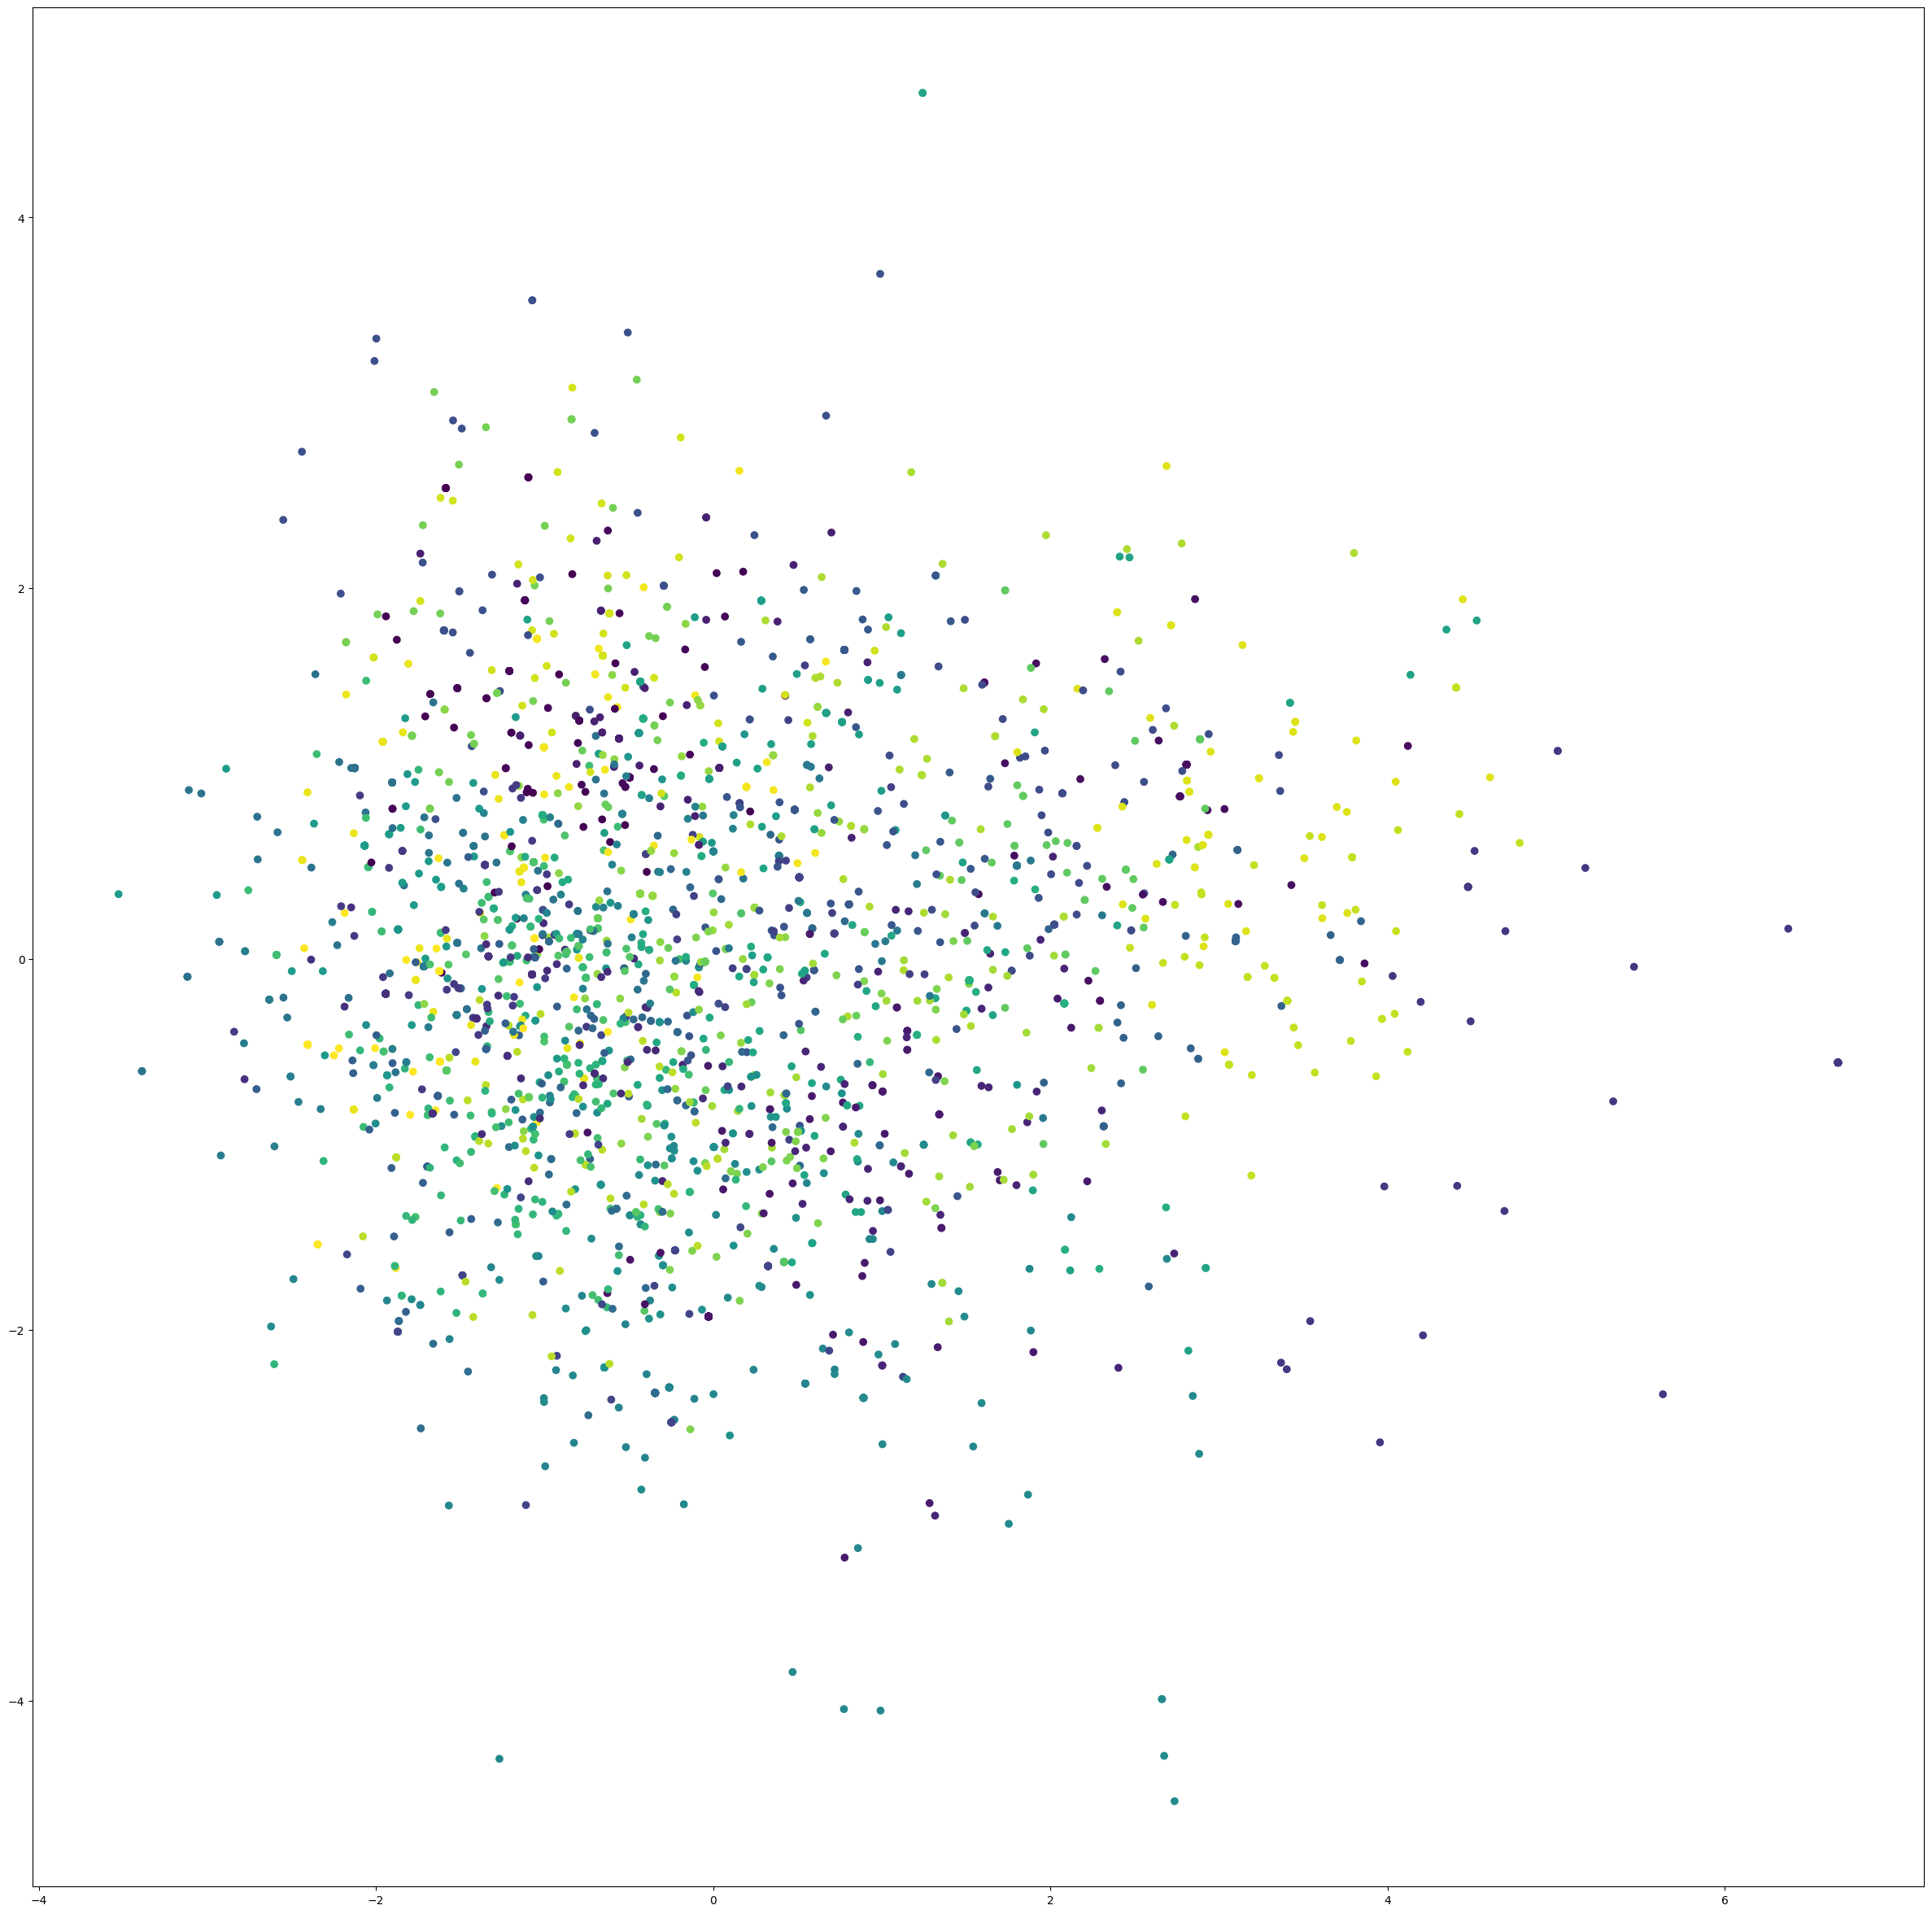

In [190]:
# sns.set(rc={"figure.figsize":(8, 4)})
# sns.scatterplot(x='PC1',y='PC2', hue='cluster', data=pca_plot_data)

fig, ax = plt.subplots(figsize=(30, 30))
ax.scatter(pca_plot_data["PC1"], pca_plot_data["PC2"], c=pca_plot_data["cluster"])

In [191]:
# feature = "danceability"
# features = X.columns.tolist()
# plot_feats = [f for f in features if f != feature]
# len(plot_feats)
# fig, axs = plt.subplots(8, 1, figsize=(15, 45))

# for feat, ax in zip(plot_feats, axs.ravel()):
#    ax[0, ]

# for i in range(len(plot_feats)):
#   axs[0][i].scatter(df_join[plot_feats[i]], df_join[feature], c=df_join["cluster"])


# axs[0].scatter(df_join["energy"], df_join["danceability"], c=df_join["cluster"])
# axs[1].scatter(df_join["key"], df_join["danceability"], c=df_join["cluster"])
# axs[2].scatter(df_join["loudness"], df_join["danceability"], c=df_join["cluster"])
# axs[3].scatter(df_join["mode"], df_join["danceability"], c=df_join["cluster"])
# axs[4].scatter(df_join["speechiness"], df_join["danceability"], c=df_join["cluster"])
# axs[5].scatter(df_join["acousticness"], df_join["danceability"], c=df_join["cluster"])
# axs[6].scatter(df_join["instrumentalness"], df_join["danceability"], c=df_join["cluster"])
# axs[7].scatter(df_join["liveness"], df_join["danceability"], c=df_join["cluster"])

# plt.show()

In [192]:
# features = X.columns.tolist()
# plot_features(df_join, "danceability", features, "cluster")

In [193]:
# cols1 = X.columns.tolist()
# cols2 = ["market_id", "playlist_rank", "cluster"]
# analysis_df = df_join[cols1 + cols2]

# analysis_df.head(10)

In [194]:
# len(analysis_df[analysis_df.cluster == 16]['market_id'].unique())
country_map_dic = {}
country_counts_dic = {}
clusters = []
countries = []

analysis_df = df_join_final.copy()
# analysis_df = analysis_df.select_dtypes(exclude=["object", "bool"])

for c in np.sort(analysis_df.cluster.unique()).tolist():
    clusters.append(c)
    countries.append(len(analysis_df[analysis_df.cluster == c]["market_id"].unique()))
    country_map_dic[c] = len(analysis_df[analysis_df.cluster == c]["market_id"].unique())
country_counts_dic["clusters"] = clusters
country_counts_dic["countries"] = countries

In [195]:
# len(analysis_df[analysis_df.cluster == 16]['market_id'].unique())
def create_cluster_plot_df(analysis_df: pd.DataFrame):
    country_map_dic = {}
    country_counts_dic = {}
    clusters = []
    countries = []

    # analysis_df = df_join_final.copy()
    # analysis_df = analysis_df.select_dtypes(exclude=["object", "bool"])

    for c in np.sort(analysis_df.cluster.unique()).tolist():
        clusters.append(c)
        countries.append(len(analysis_df[analysis_df.cluster == c]["market_id"].unique()))
        country_map_dic[c] = len(analysis_df[analysis_df.cluster == c]["market_id"].unique())
    country_counts_dic["clusters"] = clusters
    country_counts_dic["countries"] = countries

    plot_df = pd.DataFrame(country_counts_dic)

    return plot_df

In [196]:
# df_join_final.info()
# country_counts_dic

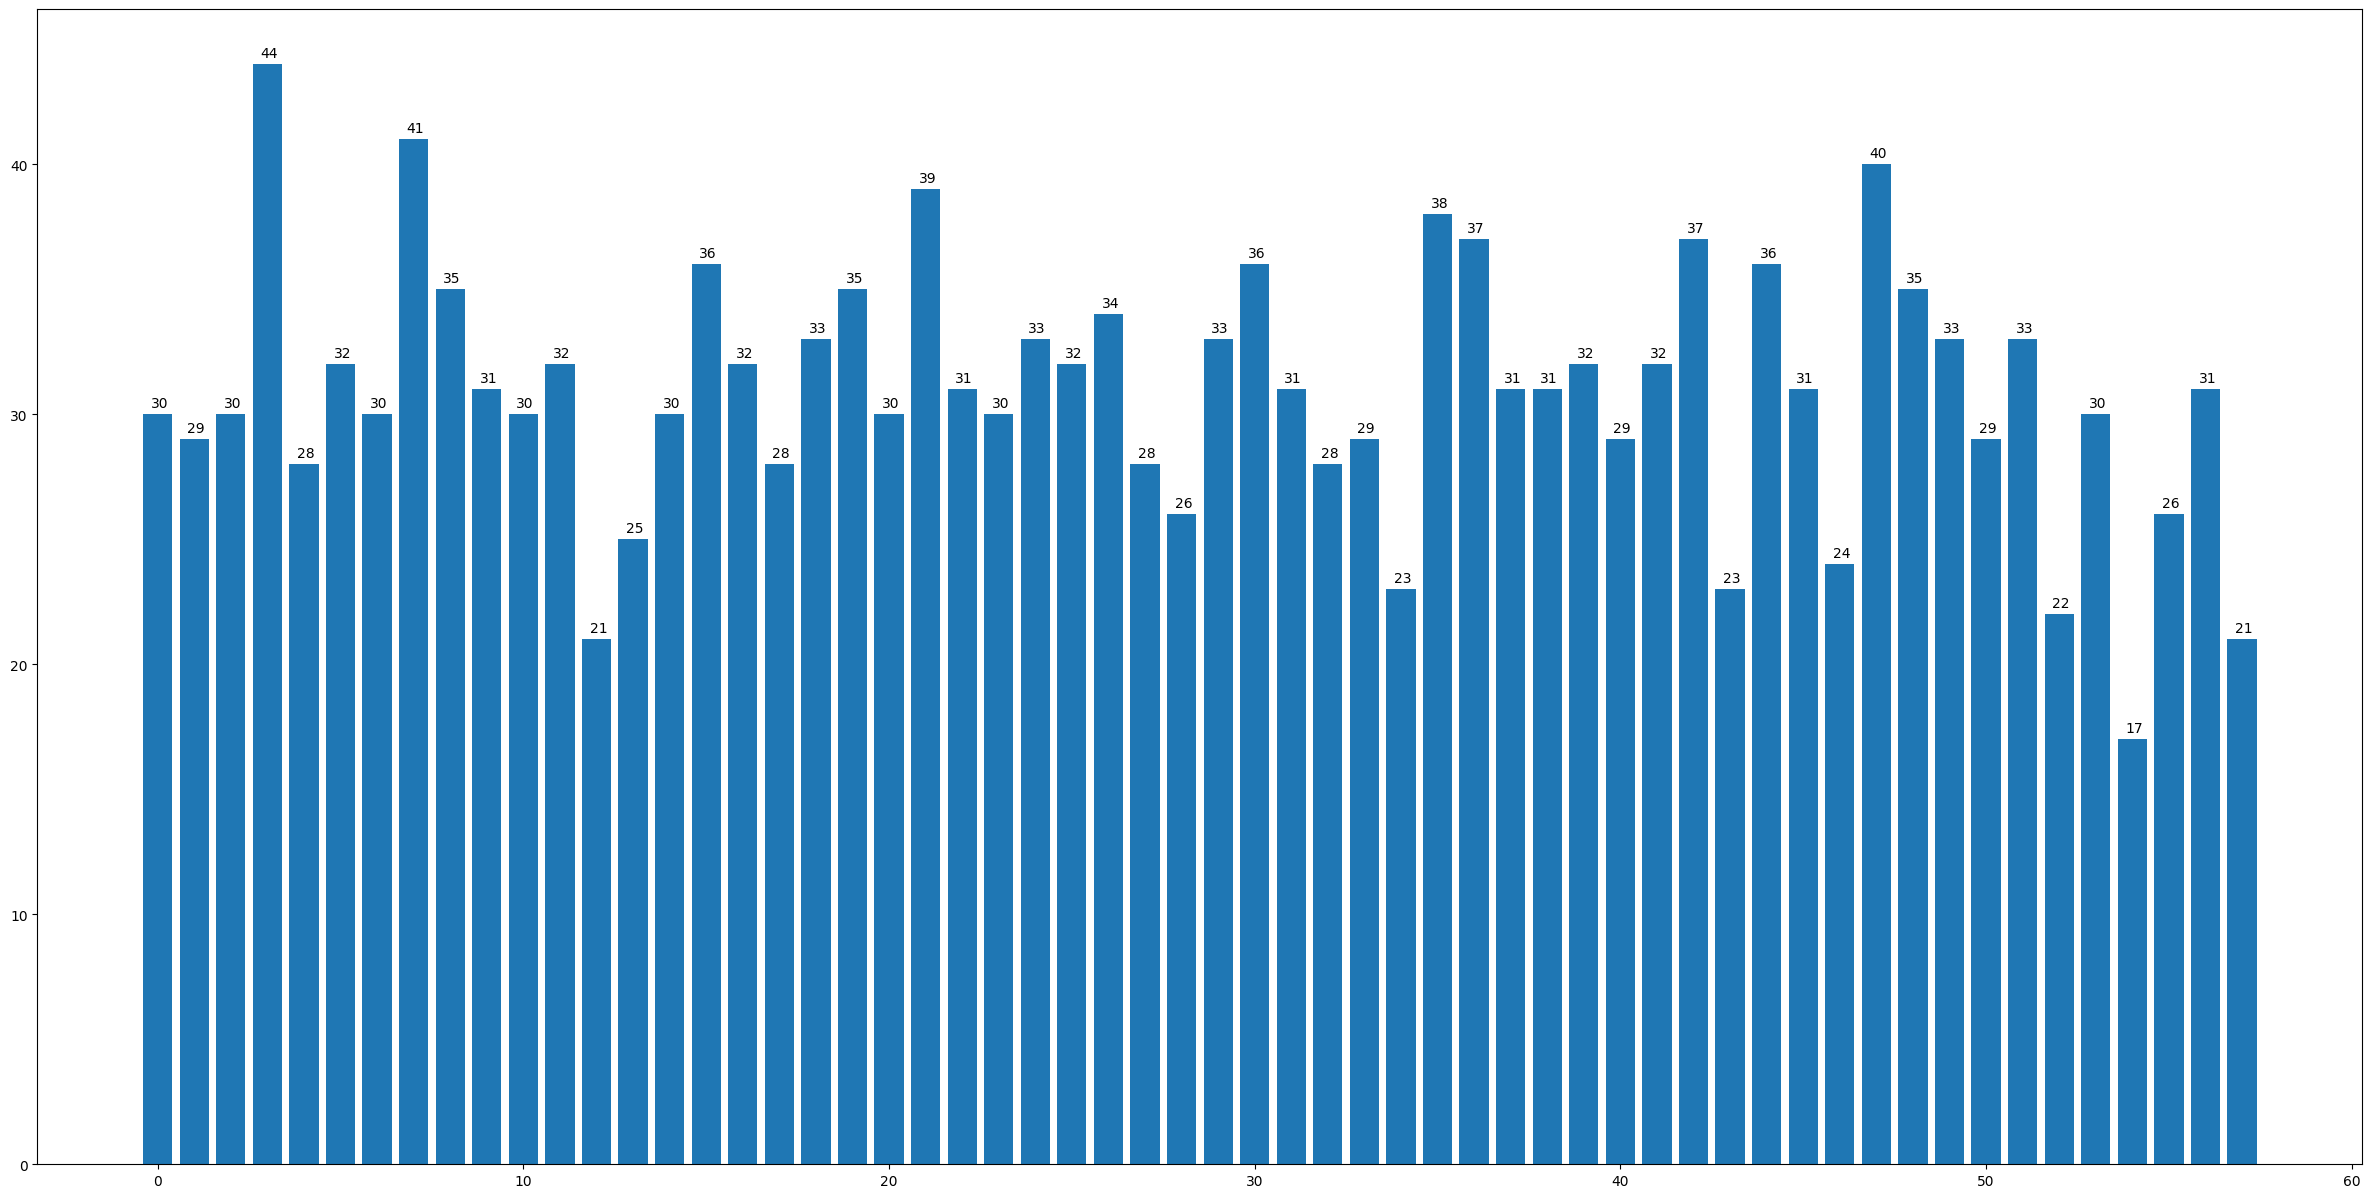

In [197]:
# [k:v for k,v in country_counts_dic.items()]

plot_df = pd.DataFrame(country_counts_dic)  # ), index = np.arange(len(country_counts_dic)))

fig, ax = plt.subplots(figsize=(30, 15))

annotations = plot_df["countries"].tolist()
ax.bar(plot_df["clusters"], plot_df["countries"])
# ax.setxticks()
for xi, yi, text in zip(plot_df["clusters"], plot_df["countries"], annotations):
    ax.annotate(text, xy=(xi, yi), xycoords="data", xytext=(-5, 5), textcoords="offset points")

In [198]:
def plot_cluster_countries(plot_df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(30, 15))

    annotations = plot_df["countries"].tolist()
    ax.bar(plot_df["clusters"], plot_df["countries"])
    # ax.setxticks()
    for xi, yi, text in zip(plot_df["clusters"], plot_df["countries"], annotations):
        ax.annotate(text, xy=(xi, yi), xycoords="data", xytext=(-5, 5), textcoords="offset points")

    return plt.show()

In [199]:
analysis_df["countries"] = analysis_df.cluster.map(lambda x: country_map_dic[x])
analysis_df = analysis_df.select_dtypes(exclude=["object", "bool"])
analysis_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,num_avail_markets,num_artists,playlist_rank,cluster,countries
0,0.638,0.716,6.0,-7.287,0.0,0.0696,0.160,0.000000,0.3660,0.833,150.124,157600.0,4.0,64,184,1,23,35,38
1,0.401,0.394,1.0,-6.655,1.0,0.0324,0.748,0.000000,0.0993,0.327,129.740,274387.0,4.0,59,184,1,33,54,17
2,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,0.889,94.039,190005.0,4.0,83,180,2,43,40,29
3,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,0.889,94.039,190005.0,4.0,83,180,2,41,40,29
4,0.581,0.558,5.0,-10.404,1.0,0.0432,0.627,0.000220,0.1020,0.271,76.992,281494.0,4.0,63,183,1,41,43,23
5,0.587,0.810,9.0,-3.519,0.0,0.0962,0.161,0.000000,0.1210,0.424,157.863,184488.0,4.0,61,183,1,45,0,30
6,0.639,0.286,5.0,-7.472,0.0,0.0397,0.945,0.000000,0.1200,0.393,133.851,197015.0,4.0,56,184,1,43,18,33
7,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,0.551,77.656,227691.0,4.0,60,184,2,33,50,29
8,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,0.551,77.656,227691.0,4.0,60,184,2,44,50,29
9,0.878,0.309,6.0,-9.548,1.0,0.4750,0.283,0.000000,0.1010,0.637,76.008,152368.0,4.0,52,183,1,28,27,28


In [200]:
most_countries_df = analysis_df[analysis_df["countries"].astype(int) >= 37]  # .drop("market_id", axis=1)
least_countries_df = analysis_df[analysis_df["countries"].astype(int) <= 22]  # .drop("market_id", axis=1)

In [201]:
most_countries_df.groupby("cluster").mean()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,,
3,0.85982,0.54738,5.20,-8.63580,1.00,0.168868,0.275740,0.000359,0.092574,0.74682,104.43386,219665.84,4.00,94.74,183.12,1.04,10.72,44.0
7,0.78528,0.76732,5.86,-6.20966,0.00,0.074698,0.140289,0.000412,0.111368,0.48904,125.86462,168095.12,4.00,76.06,162.42,1.48,26.54,41.0
21,0.71632,0.84900,10.36,-4.60708,0.00,0.062808,0.065983,0.003770,0.326600,0.77764,115.55450,176954.74,3.94,85.94,181.58,1.38,27.12,39.0
35,0.65752,0.69584,7.44,-6.37386,0.00,0.055798,0.347870,0.000385,0.317392,0.72020,134.57890,185640.34,3.72,79.70,179.60,1.70,27.62,38.0
36,0.62412,0.49690,10.36,-8.27760,0.00,0.094216,0.709800,0.003641,0.182842,0.42190,148.32520,177071.22,4.04,86.92,183.38,1.06,18.46,37.0
42,0.81156,0.61946,1.88,-7.05134,0.96,0.175576,0.177028,0.000572,0.342780,0.73802,114.41414,175498.06,4.00,80.96,181.30,2.24,28.38,37.0
47,0.55422,0.72104,8.76,-5.66686,0.92,0.145590,0.095167,0.000215,0.116086,0.61262,158.30554,179973.50,3.96,83.04,182.44,1.24,24.94,40.0


In [202]:
least_countries_df.groupby("cluster").mean()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,,
12,0.72366,0.64020,2.04,-5.07488,0.00,0.318860,0.403190,0.000450,0.095768,0.582300,141.50354,194399.18,3.98,80.66,182.84,1.82,32.38,21.0
52,0.55288,0.31786,8.28,-10.69500,0.96,0.047030,0.823440,0.010378,0.143328,0.339562,116.59242,220382.98,3.88,76.08,183.72,1.16,28.24,22.0
54,0.46856,0.39120,3.38,-7.96618,1.00,0.033904,0.763140,0.005951,0.145680,0.298352,123.09776,232343.00,3.84,76.36,183.44,1.12,26.54,17.0
57,0.83326,0.78890,4.56,-3.61066,0.00,0.094110,0.130333,0.000716,0.095528,0.595900,115.21284,192240.48,4.00,82.02,183.52,1.98,23.36,21.0


In [203]:
# df_join.key.unique()

In [204]:
most_countries_df.groupby("cluster").var()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,,
3,0.001754,0.001261,0.979592,0.100705,0.000000,0.000728,0.004349,3.188202e-06,0.000281,0.002603,287.633901,8.185522e+08,0.000000,155.298367,0.107755,0.039184,131.307755,0.0
7,0.003227,0.004526,1.265714,1.012489,0.000000,0.000726,0.005838,2.878138e-06,0.001866,0.004667,550.024251,9.345357e+08,0.000000,172.506531,3404.697551,0.581224,186.416735,0.0
21,0.003909,0.003088,1.745306,0.625085,0.000000,0.000729,0.008654,6.840755e-04,0.002964,0.007164,262.825750,4.976830e+08,0.057551,134.016735,2.779184,0.566939,179.577143,0.0
35,0.010265,0.005943,5.149388,1.971355,0.000000,0.000534,0.015908,5.267700e-07,0.005456,0.015019,774.356607,9.432799e+08,0.205714,196.989796,678.775510,0.785714,203.668980,0.0
36,0.002705,0.001603,1.214694,0.334605,0.000000,0.000760,0.004850,1.250948e-04,0.002369,0.010732,1467.499869,1.400584e+08,0.080000,113.340408,0.240408,0.098367,269.804490,0.0
42,0.003406,0.005912,3.903673,1.909604,0.039184,0.006187,0.033533,5.961141e-06,0.009383,0.016497,503.310055,1.841690e+09,0.000000,198.855510,95.316327,0.961633,162.893469,0.0
47,0.004386,0.005924,1.206531,1.013313,0.075102,0.003019,0.003323,1.222131e-06,0.001529,0.011755,719.952921,1.809783e+09,0.039184,326.610612,52.782041,0.471837,208.343265,0.0


In [205]:
least_countries_df.groupby("cluster").var()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,,
12,0.009829,0.011838,2.324898,2.112435,0.000000,0.002647,0.048411,0.000006,0.000665,0.015853,1271.097332,2.030411e+09,0.101633,148.269796,3.810612,0.681224,130.158776,0.0
52,0.011029,0.004484,3.511837,2.584156,0.039184,0.000346,0.006990,0.001303,0.006065,0.017055,872.805946,2.832563e+09,0.107755,127.585306,0.246531,0.177959,156.594286,0.0
54,0.009742,0.004037,4.403673,2.038410,0.000000,0.000051,0.006899,0.000782,0.006145,0.015878,970.553480,2.348874e+09,0.137143,105.255510,1.761633,0.189388,257.682041,0.0
57,0.004022,0.005661,3.802449,0.772635,0.000000,0.001044,0.009681,0.000007,0.001446,0.011068,694.841972,7.658951e+08,0.000000,78.591429,0.254694,0.713878,173.663673,0.0


Let's try Kmeans without setting the cluster size minimum and see what the model will cluster. 

In [206]:
kmeans2 = KMeansConstrained(n_clusters=58, size_min=None, size_max=50, random_state=random_state)
kmeans2.fit(X_scaled)

KMeansConstrained(copy_x=True, init='k-means++', max_iter=300, n_clusters=58,
         n_init=10, n_jobs=1, random_state=42, size_max=50, size_min=None,
         tol=0.0001, verbose=False)

In [207]:
analysis_df2 = df_join_final.copy()
analysis_df2["cluster"] = pd.Categorical(kmeans2.labels_)

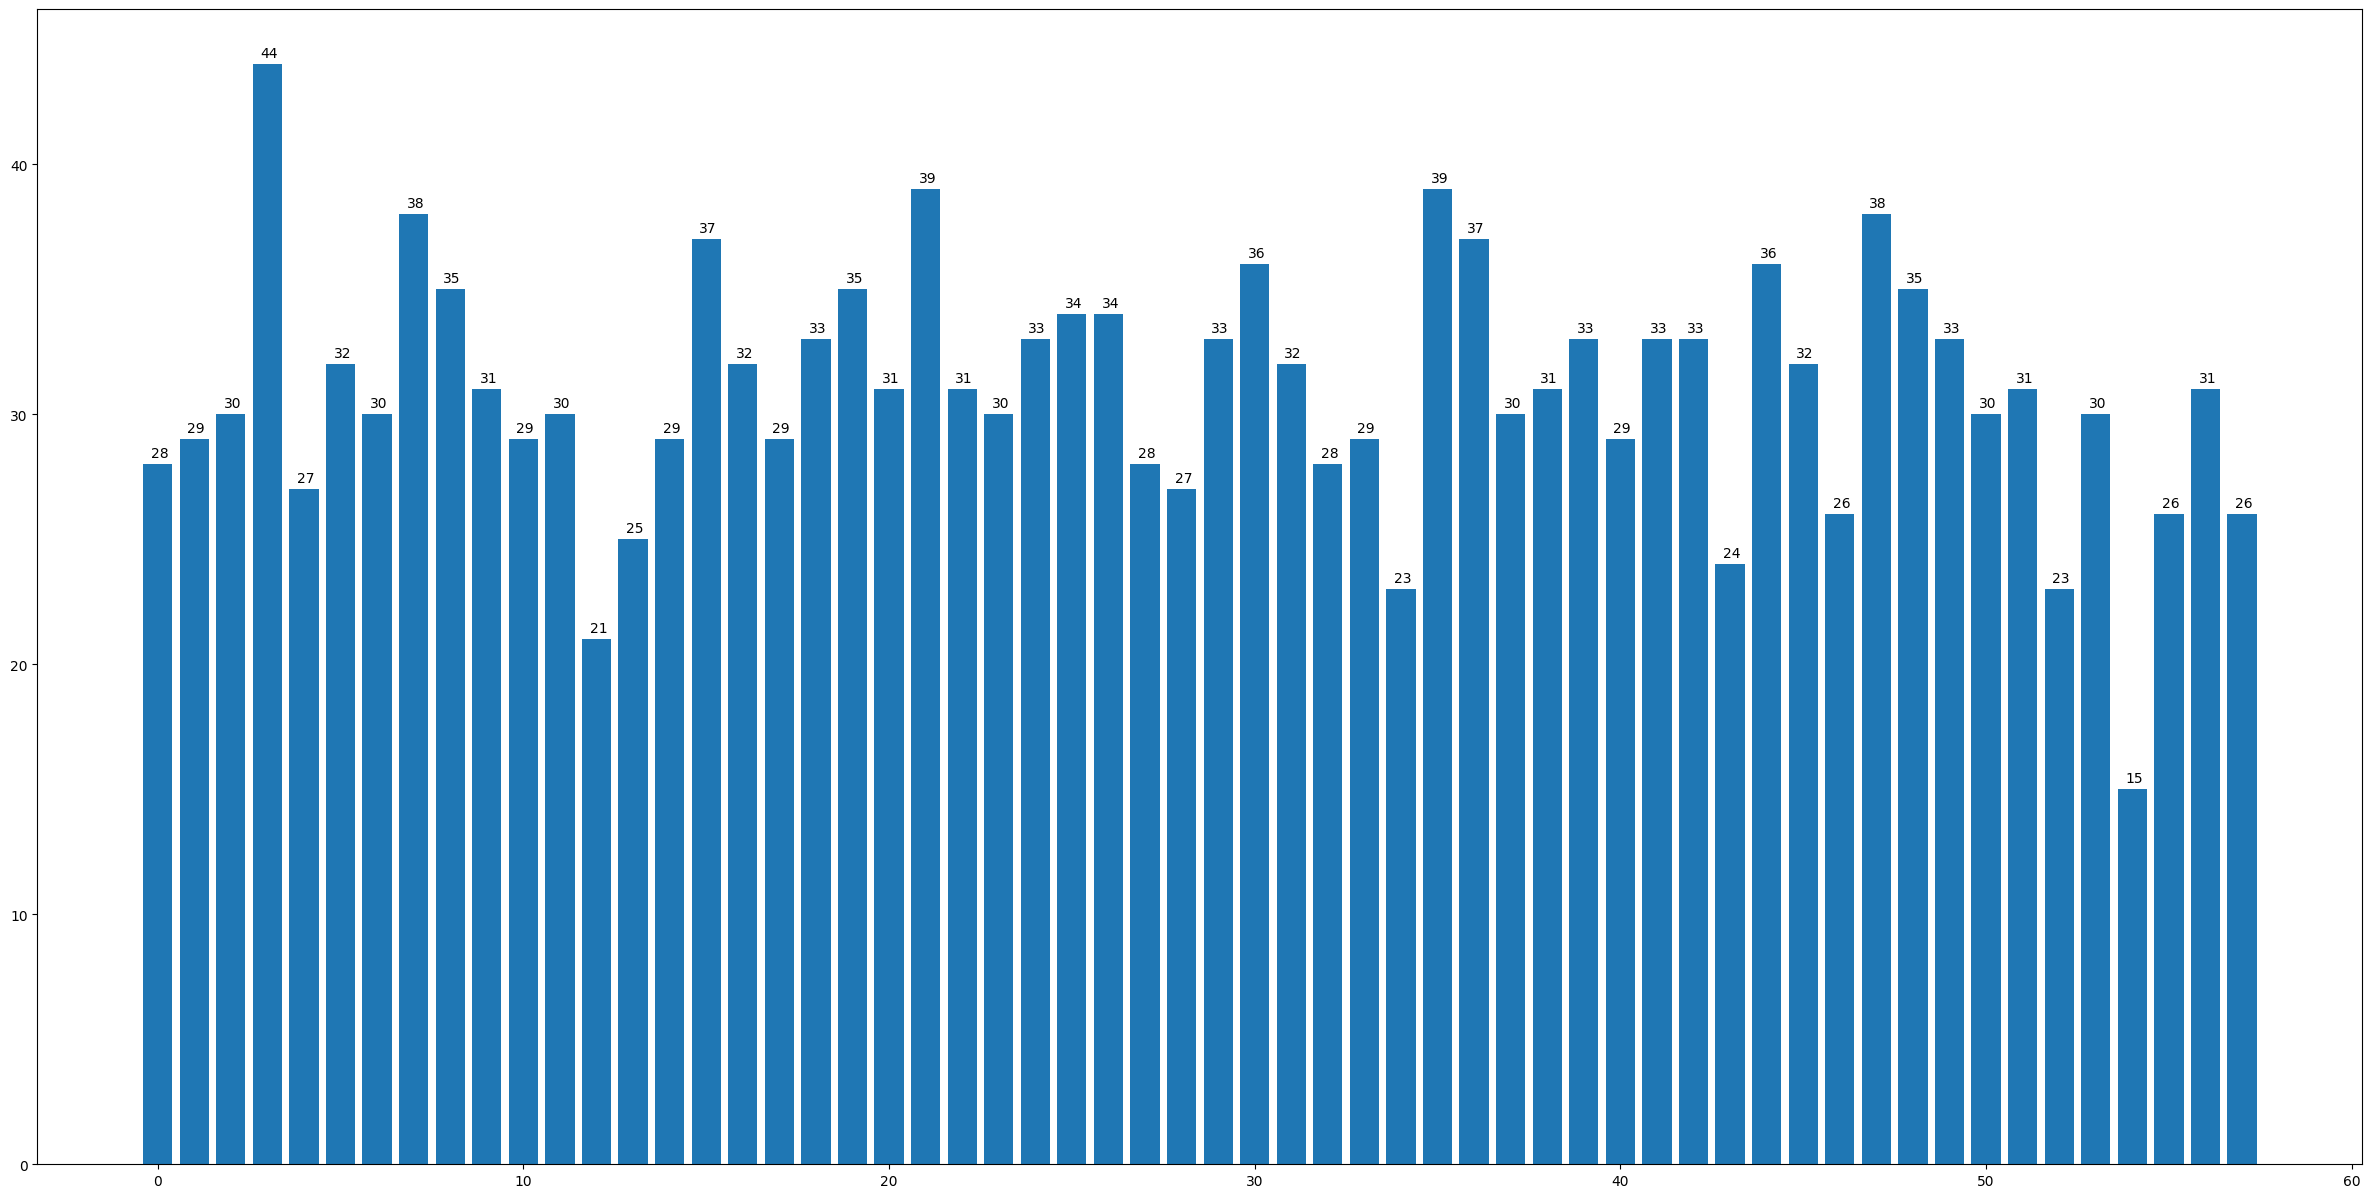

In [208]:
plot_df2 = create_cluster_plot_df(analysis_df2)
plot_cluster_countries(plot_df2)

Not much of a difference. Let's try DBSCAN

In [209]:
from sklearn.cluster import DBSCAN

dbmodel = DBSCAN(eps=0.5, min_samples=5)
dbmodel.fit(X_scaled)

DBSCAN()

In [210]:
analysis_df3 = df_join_final.copy()
analysis_df3["cluster"] = pd.Categorical(dbmodel.labels_)

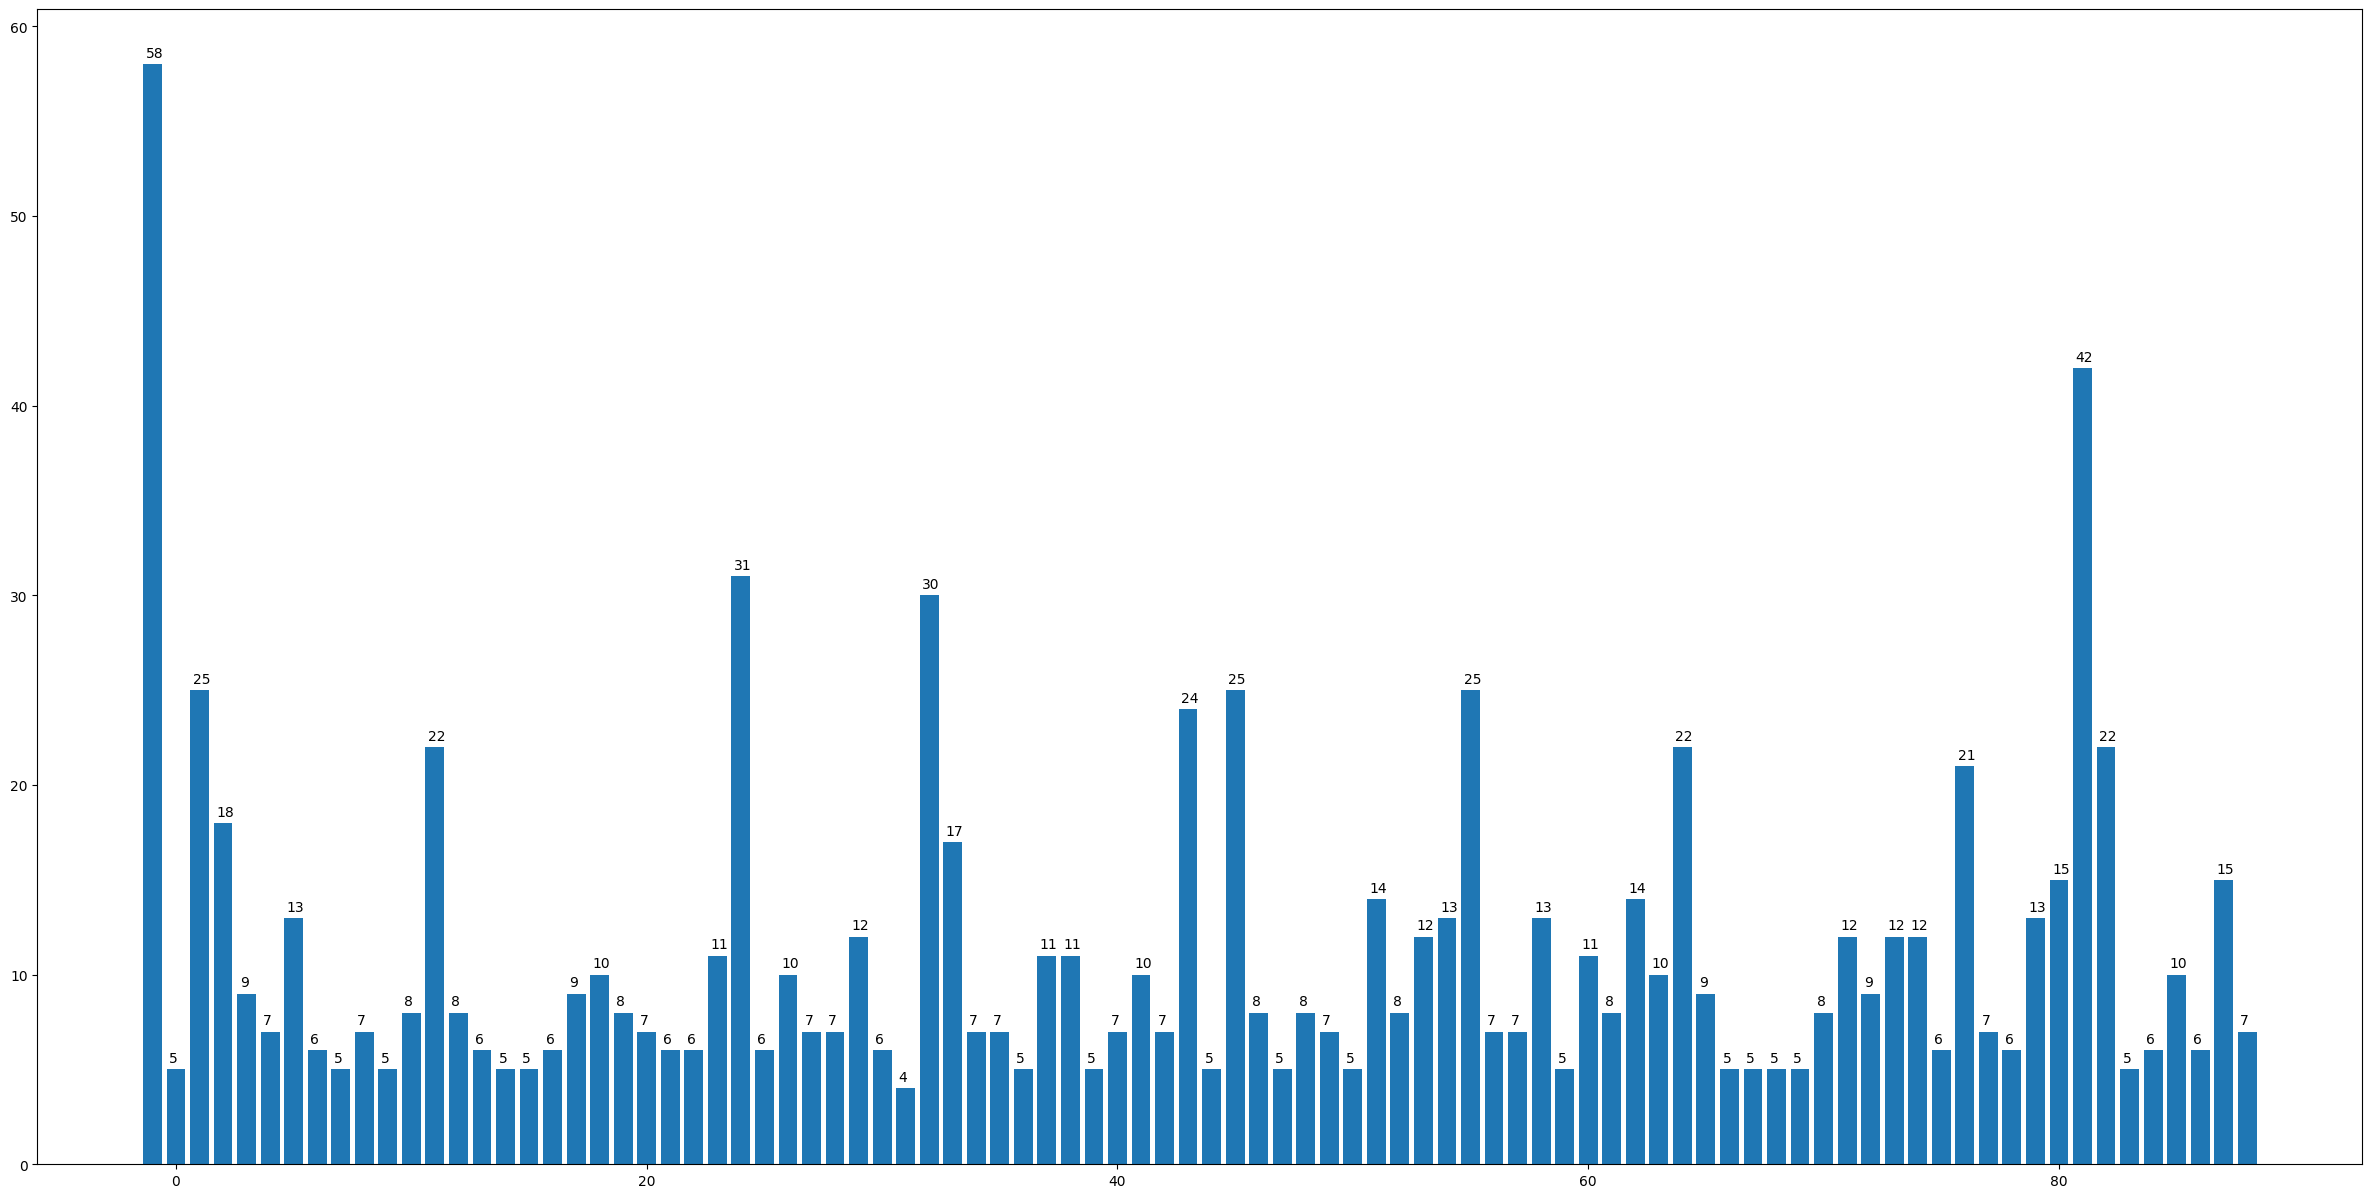

In [211]:
plot_df3 = create_cluster_plot_df(analysis_df3)
plot_cluster_countries(plot_df3)

In [212]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# pca.fit(X_scaled)

pca_plot_data2 = pd.DataFrame(pca.fit_transform(X_scaled), columns=["PC1", "PC2"])

pca_plot_data2["cluster"] = pd.Categorical(dbmodel.labels_)
pca_plot_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   PC1      2900 non-null   float64 
 1   PC2      2900 non-null   float64 
 2   cluster  2900 non-null   category
dtypes: category(1), float64(2)
memory usage: 51.0 KB


In [213]:
# fig, ax = plt.subplots(figsize=(30, 30))
# ax.scatter(pca_plot_data2['PC1'], pca_plot_data2["PC2"], c=pca_plot_data2["cluster"])

In [214]:
plot_df3[plot_df3.countries == 58]

,clusters,countries
0,-1,58


In [215]:
len(analysis_df3[analysis_df3.cluster == -1])

1961

In [216]:
test = df_join_final.select_dtypes(exclude=["object", "bool"])
countries = df_join_final.market_id.unique().tolist()
correlation_variables2 = test.columns.to_list()[:17]
# test.info()
country_corr_values, country_variables = get_country_correlations(countries, correlation_variables2, df_join_final)

In [217]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   danceability       2900 non-null   float64
 1   energy             2900 non-null   float64
 2   key                2900 non-null   float64
 3   loudness           2900 non-null   float64
 4   mode               2900 non-null   float64
 5   speechiness        2900 non-null   float64
 6   acousticness       2900 non-null   float64
 7   instrumentalness   2900 non-null   float64
 8   liveness           2900 non-null   float64
 9   valence            2900 non-null   float64
 10  tempo              2900 non-null   float64
 11  duration_ms        2900 non-null   float64
 12  time_signature     2900 non-null   float64
 13  track_popularity   2900 non-null   int64  
 14  num_avail_markets  2900 non-null   int64  
 15  num_artists        2900 non-null   int64  
 16  playlist_rank      2900 

In [218]:
X_train2 = df_join_final[correlation_variables2]
X_train2 = X_train2.drop("playlist_rank", axis=1)

X_scaled2 = StandardScaler().fit_transform(X_train2)

kmeans4 = KMeansConstrained(n_clusters=58, size_min=50, size_max=50, random_state=random_state)
kmeans4.fit(X_scaled2)

pca = PCA(n_components=2)
# pca.fit(X_scaled)

pca_plot_data3 = pd.DataFrame(pca.fit_transform(X_scaled2), columns=["PC1", "PC2"])

pca_plot_data3["cluster"] = pd.Categorical(kmeans4.labels_)
pca_plot_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   PC1      2900 non-null   float64 
 1   PC2      2900 non-null   float64 
 2   cluster  2900 non-null   category
dtypes: category(1), float64(2)
memory usage: 50.1 KB


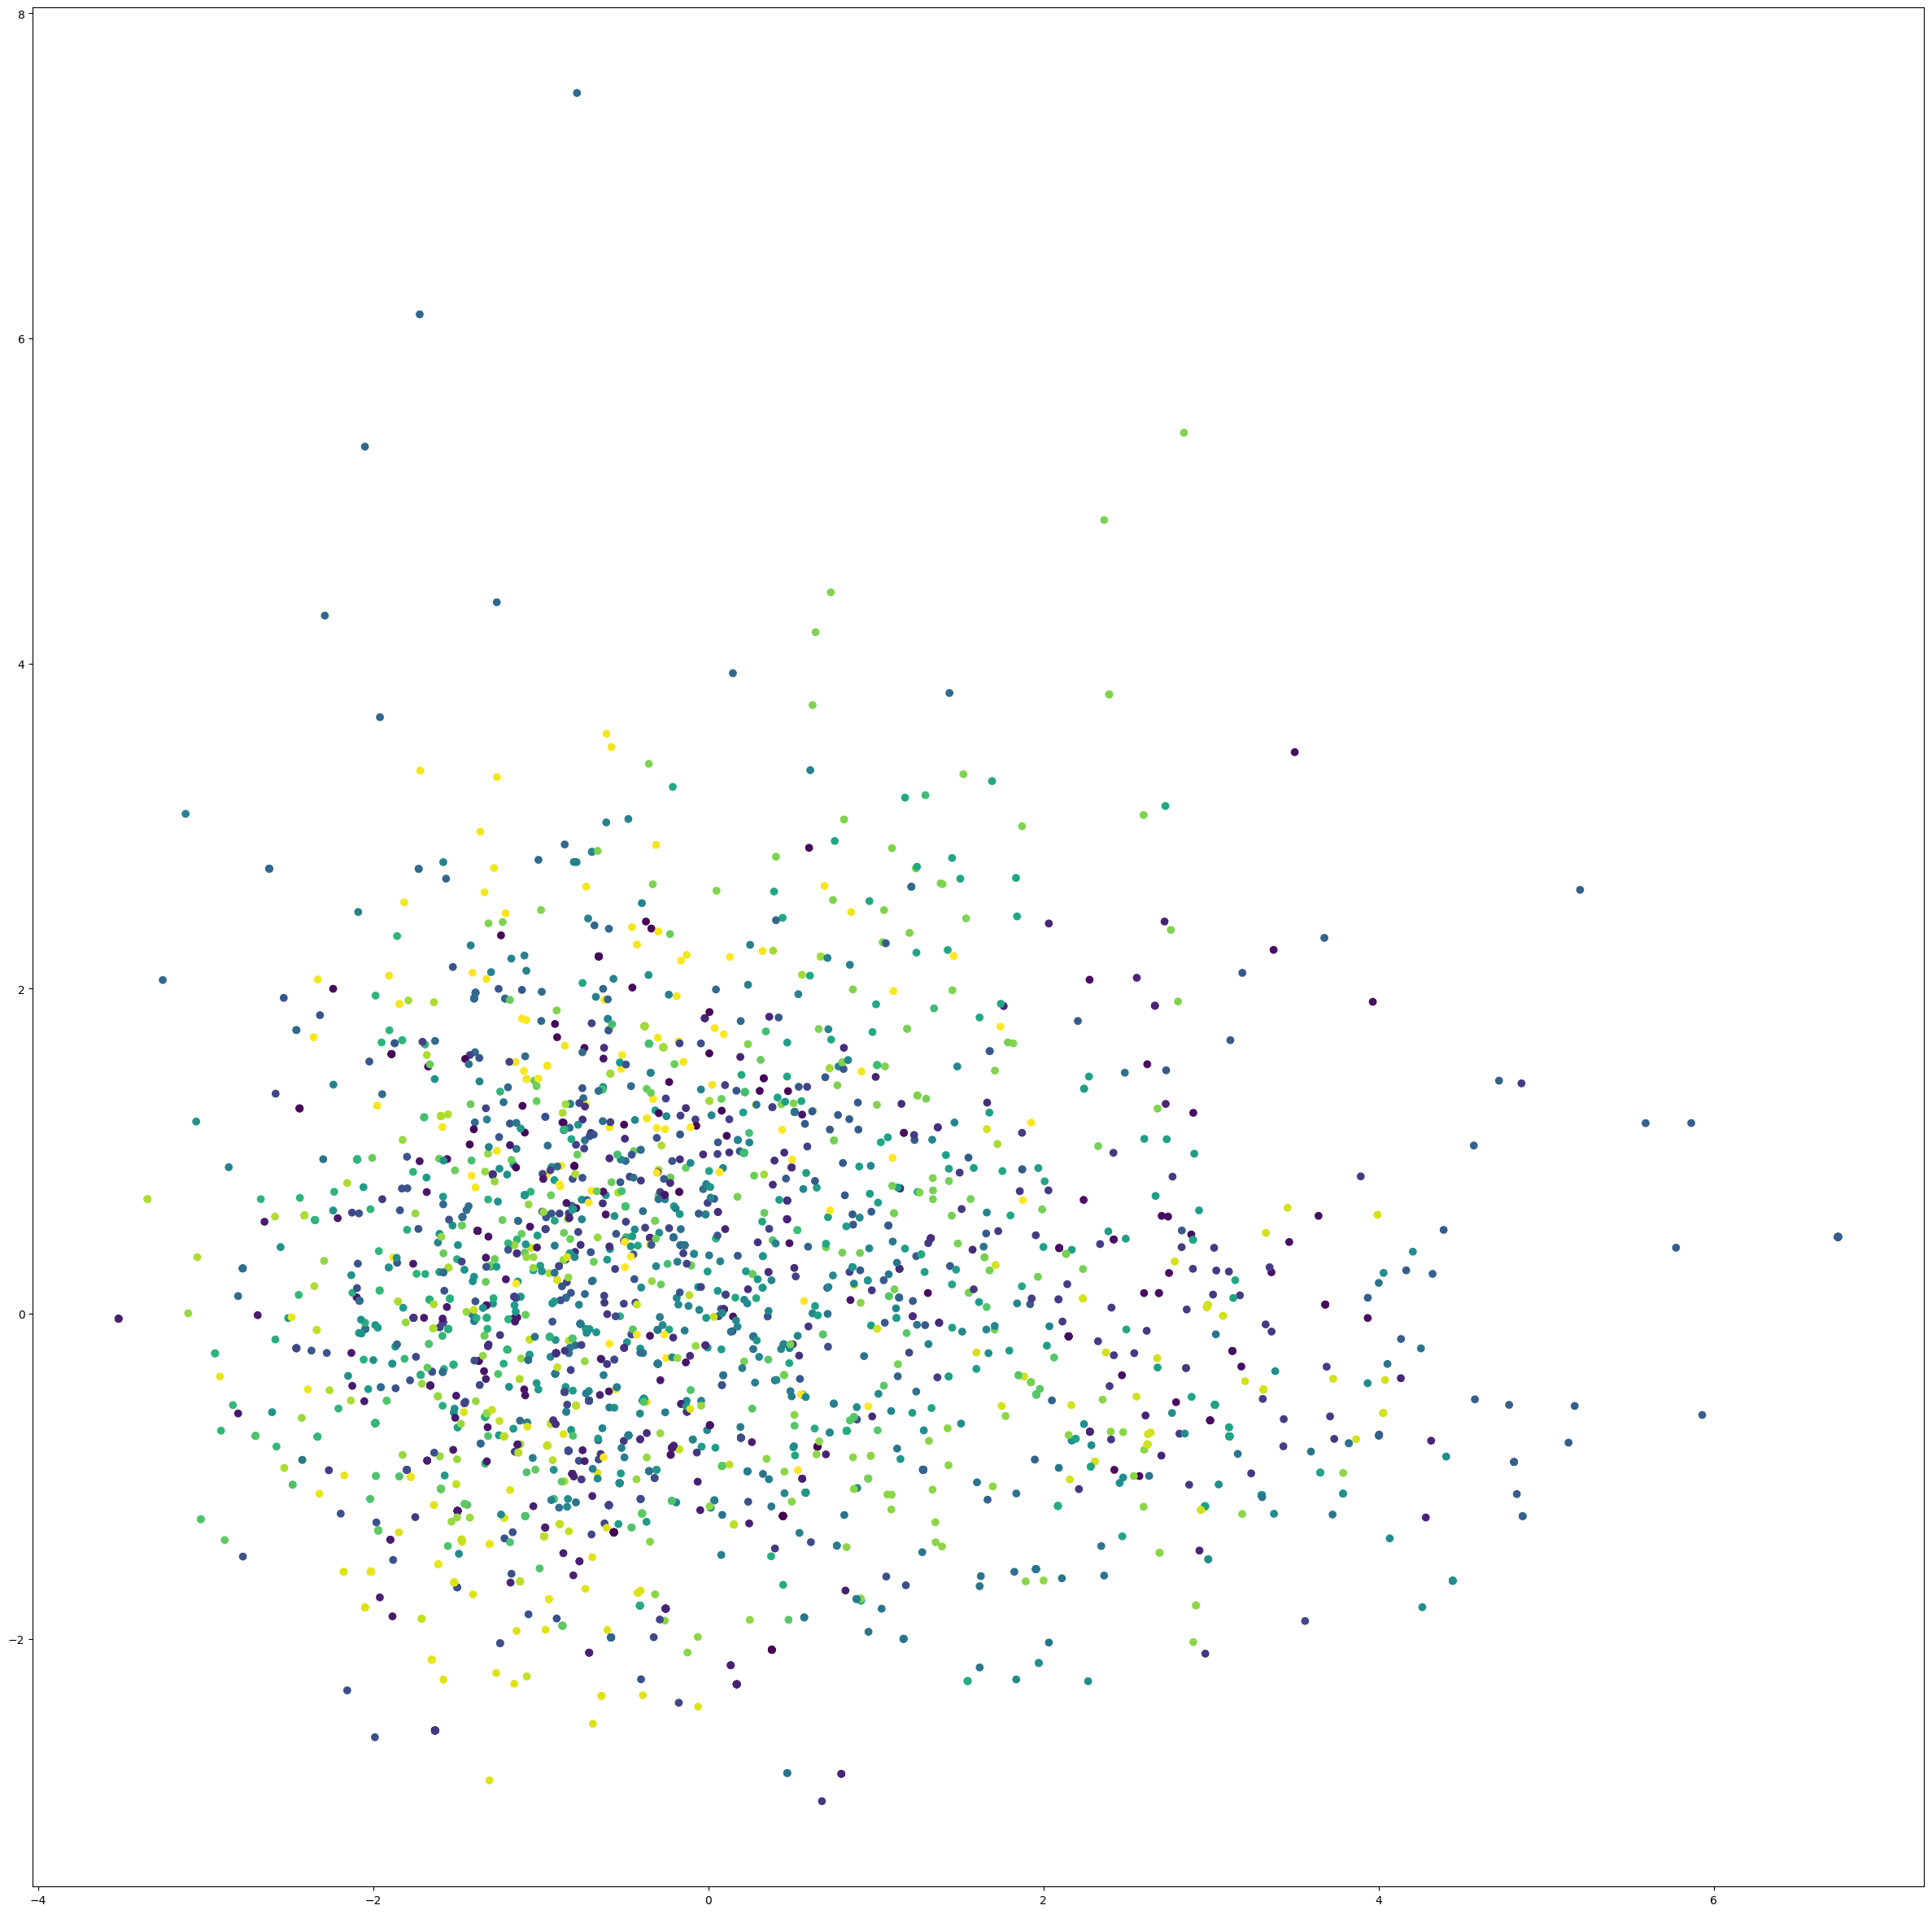

In [219]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.scatter(pca_plot_data3["PC1"], pca_plot_data3["PC2"], c=pca_plot_data3["cluster"])

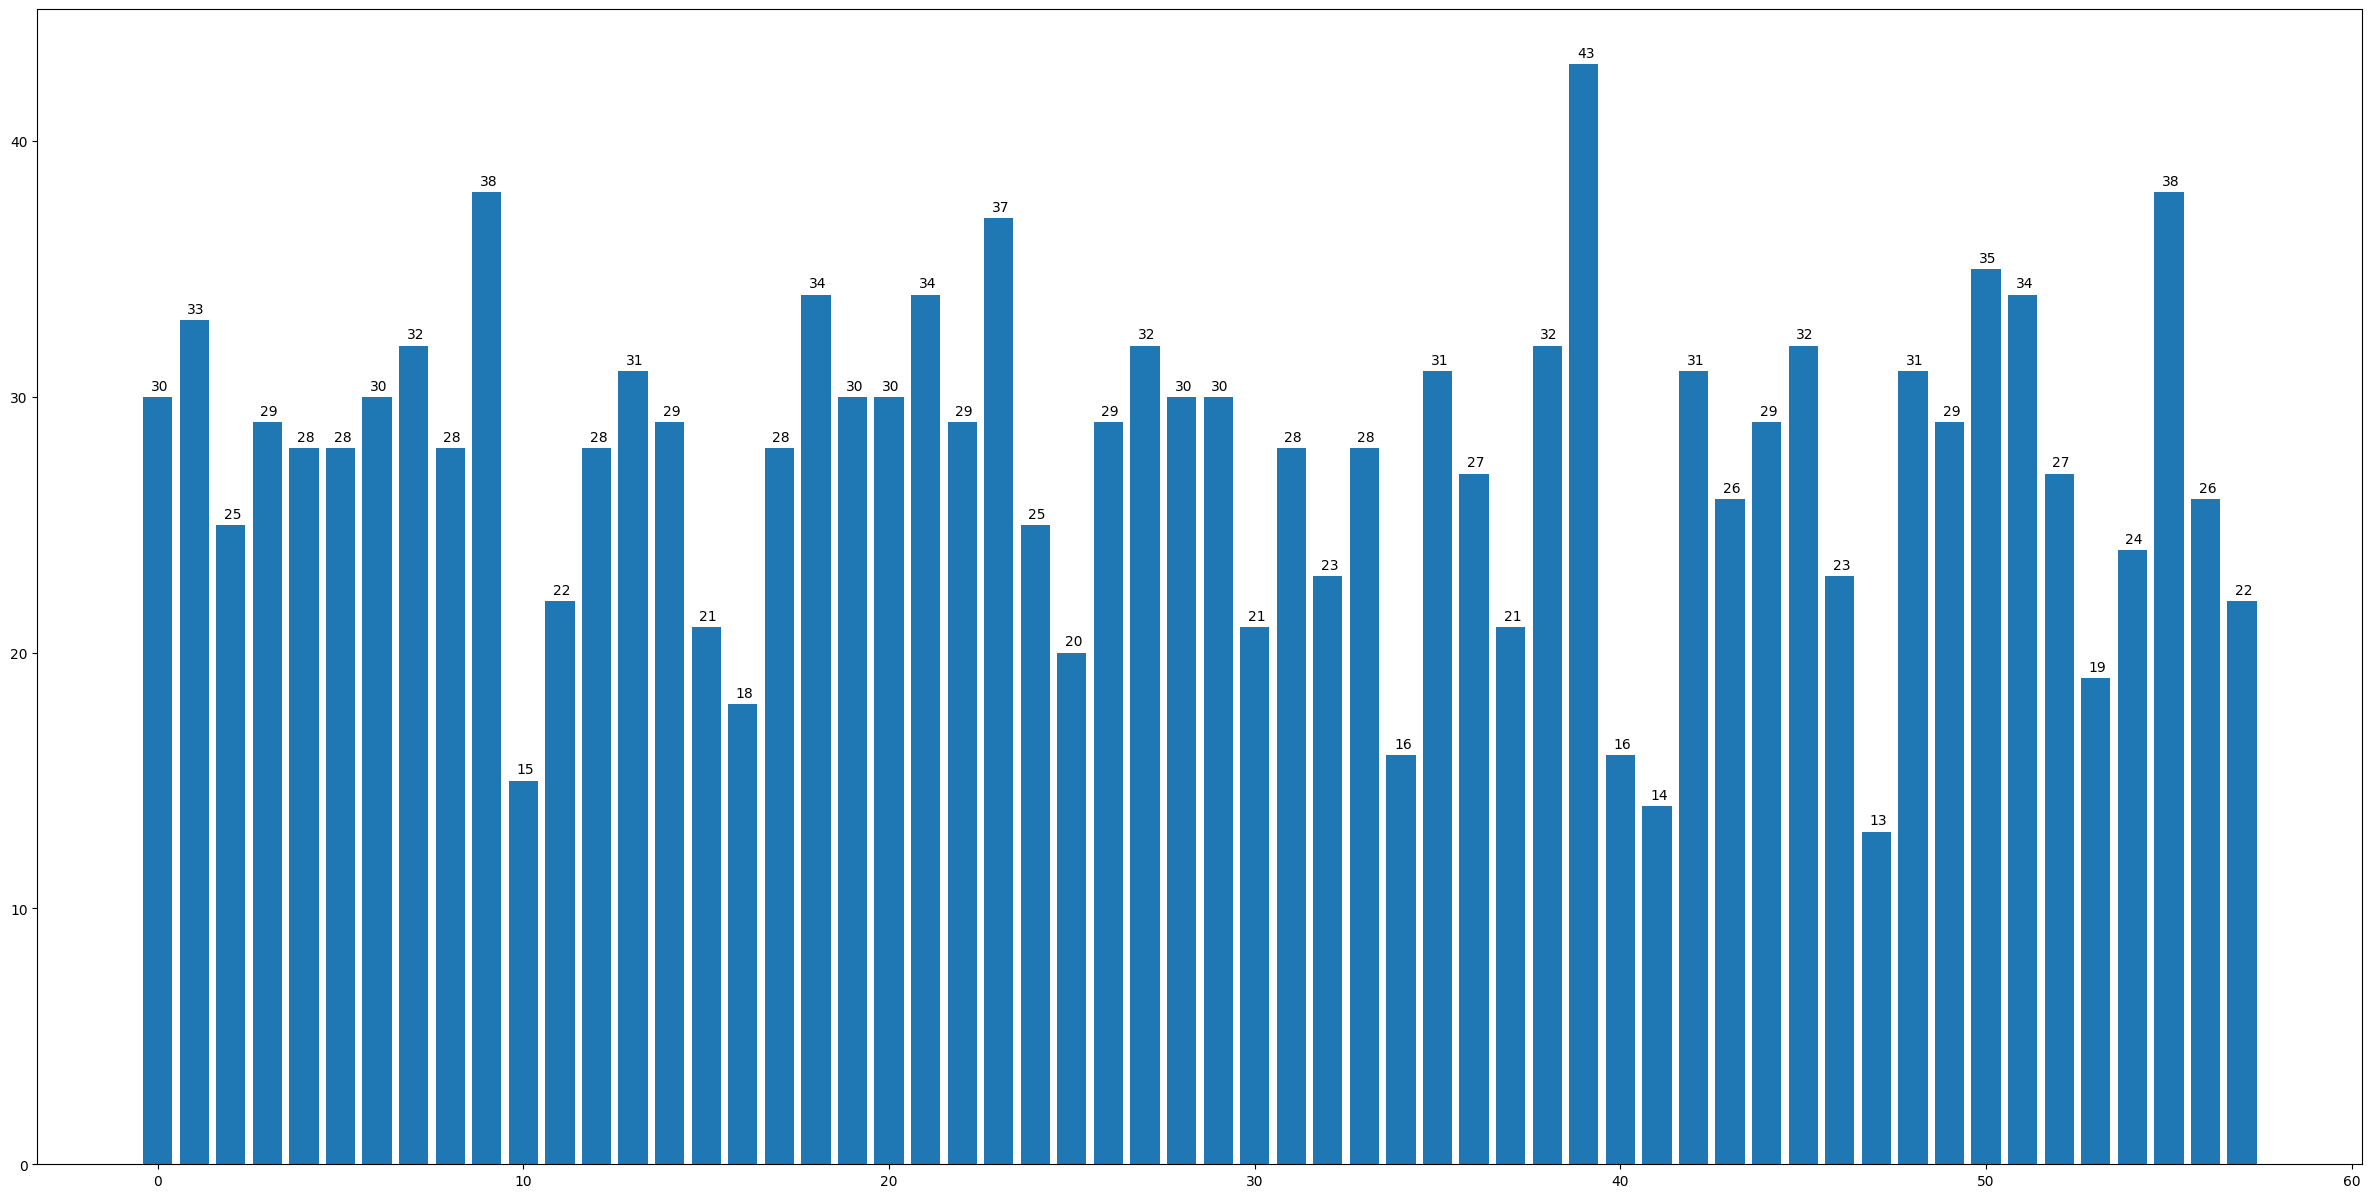

In [220]:
analysis_df4 = df_join_final.copy()
analysis_df4["cluster"] = pd.Categorical(kmeans4.labels_)

plot_df4 = create_cluster_plot_df(analysis_df4)
plot_cluster_countries(plot_df4)

In [221]:
from sklearn.cluster import AgglomerativeClustering
import gower

cols = df_join_final.columns.tolist()


gower_features = cols[1:14] + cols[19:21] + cols[22:24]
gower_features

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'explicit',
 'track_popularity',
 'num_avail_markets',
 'num_artists']

In [223]:
# scale_cols = gower_features[:2] + gower_features[3:-5] + gower_features[-2: -1]
# X_scaled3 = StandardScaler().fit_transform(df_join_final[scale_cols])
X_gower = gower.gower_matrix(df_join_final[gower_features])
agg_model = AgglomerativeClustering(n_clusters=58, compute_distances=True, linkage="complete")
agg_model.fit(X_gower)

c:\Users\Brandyn\AppData\Local\pypoetry\Cache\virtualenvs\spotify-market-popularity-KA5Pt_h3-py3.11\Lib\site-packages\sklearn\cluster\_agglomerative.py:567: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(compute_distances=True, linkage='complete',
                        n_clusters=58)

In [224]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

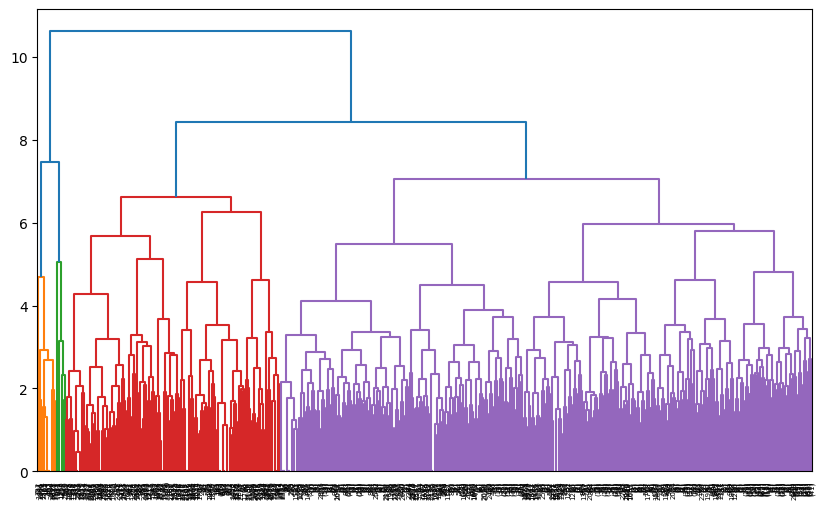

In [225]:
from scipy.cluster.hierarchy import ward, dendrogram

plt.figure(figsize=(10, 6))


plot_dendrogram(agg_model, truncate_mode="level", p=10)
plt.show()

In [226]:
analysis_df5 = df_join_final.copy()
analysis_df5["cluster"] = pd.Categorical(agg_model.labels_)
analysis_df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   track_id           2900 non-null   object  
 1   danceability       2900 non-null   float64 
 2   energy             2900 non-null   float64 
 3   key                2900 non-null   float64 
 4   loudness           2900 non-null   float64 
 5   mode               2900 non-null   float64 
 6   speechiness        2900 non-null   float64 
 7   acousticness       2900 non-null   float64 
 8   instrumentalness   2900 non-null   float64 
 9   liveness           2900 non-null   float64 
 10  valence            2900 non-null   float64 
 11  tempo              2900 non-null   float64 
 12  duration_ms        2900 non-null   float64 
 13  time_signature     2900 non-null   float64 
 14  track_name         2900 non-null   object  
 15  playlist_id        2900 non-null   object  
 16  album_

In [227]:
# fig, axs = plt.subplots(5, 1, figsize=(30, 30))
# fig, axs = plt.subplots( figsize=(30, 30))
# axs.scatter(analysis_df5["track_popularity"], analysis_df5["num_avail_markets"], c=analysis_df5["cluster"])
# axs[1].scatter(df_join_final["valence"], df_join_final["danceability"], c=df_join_final["cluster"])
# axs[2].scatter(df_join_final["valence"], df_join_final["tempo"], c=df_join_final["cluster"])
# axs[3].scatter(df_join_final["tempo"], df_join_final["energy"], c=df_join_final["cluster"])
# axs[4].scatter(df_join_final["tempo"], df_join_final["danceability"], c=df_join_final["cluster"])
# axs[3].scatter(df_join_final["valence"], df_join_final["energy"], c=df_join_final["cluster"])

In [228]:
pca = PCA(n_components=2)
# pca.fit(X_scaled)
pca.fit_transform(X_gower)
# pca_plot_data = pd.DataFrame(pca.fit_transform(X_gower), columns=["PC1", "PC2"])

# pca_plot_data["cluster"] = pd.Categorical(kmeans.labels_)
# pca_plot_data.info()
len(pca.components_[0])

2900

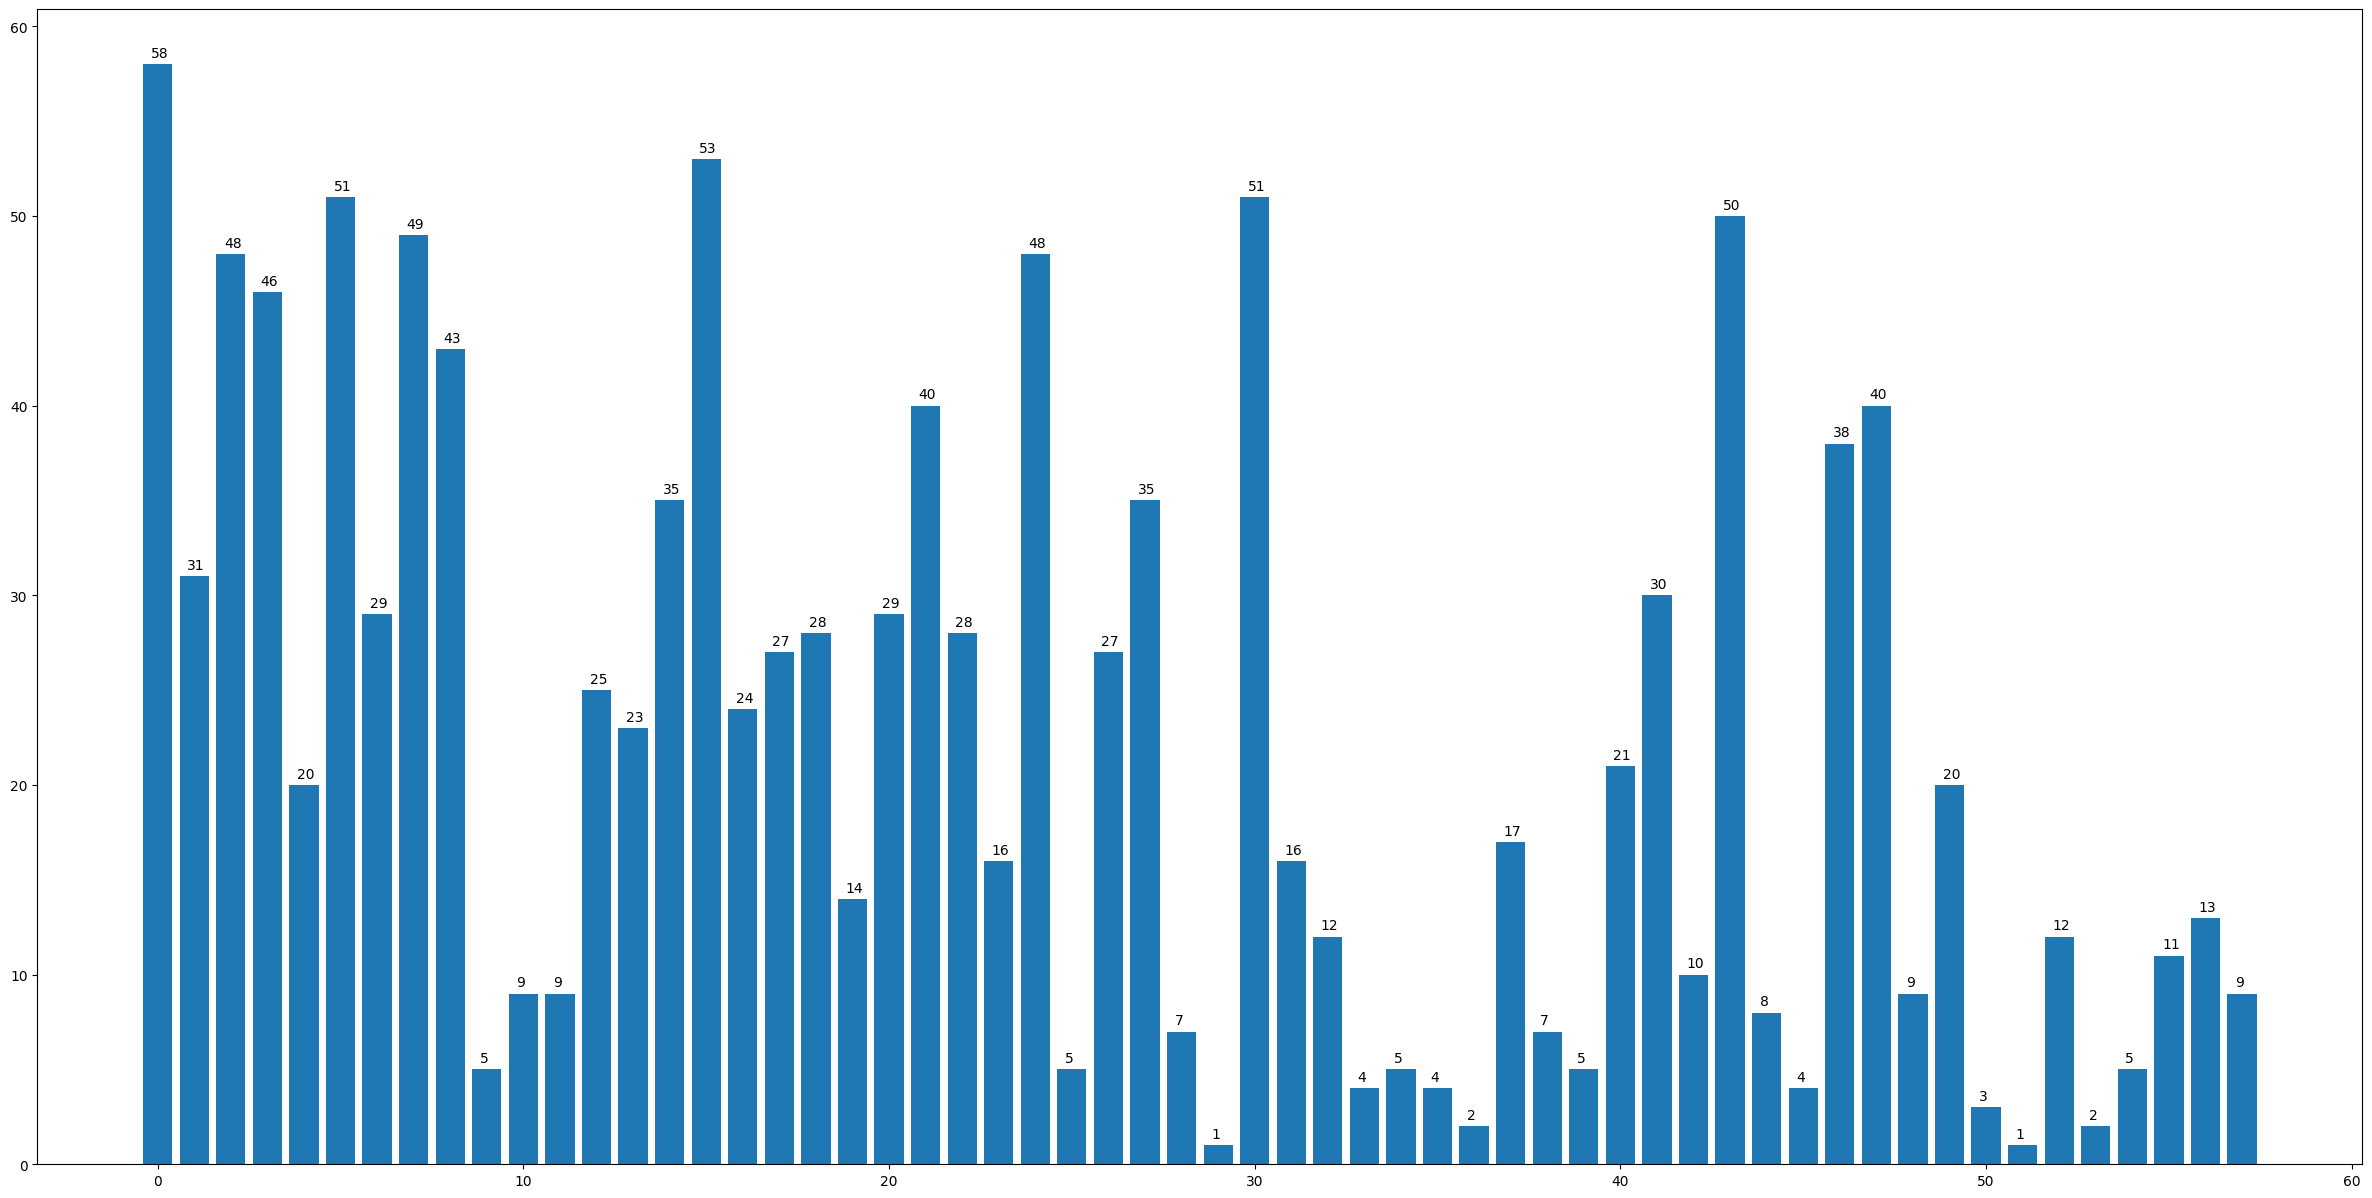

In [229]:
plot_df5 = create_cluster_plot_df(analysis_df5)
plot_cluster_countries(plot_df5)

In [230]:
country_map_dic = {plot_df5["clusters"][i]: plot_df5["countries"][i] for i in range(len(plot_df5))}

analysis_df5["countries"] = analysis_df5.cluster.map(lambda x: country_map_dic[x])
# analysis_df5 = analysis_df.select_dtypes(exclude=["object", "bool"])
# analysis_df5[analysis_df5.cluster == 0].head(10)
# plot_df5.info()
analysis_df5.head(10)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank,cluster,countries
0,7r8FHPasw67Nl4Hqyd4685,0.638,0.716,6.0,-7.287,0.0,0.0696,0.160,0.000000,0.3660,...,5WJLZ54uK7ni636O65EztT,[{'id': '1Kj6Km5IuLGKt2cxuhSgLm'}],True,64,norway,184,1,23,3,46
1,2RLdkXSaiQjRbey5pvP8Kt,0.401,0.394,1.0,-6.655,1.0,0.0324,0.748,0.000000,0.0993,...,5ITErfEiF1nEo8KTRgLv43,[{'id': '75MOYjGEyyH5U4ZFHOPvxR'}],False,59,south_korea,184,1,33,32,12
2,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,...,464FQ8gr0oKlQ1a0TCK4Yj,"[{'id': '2R21vXR83lH98kGeO99Y66'}, {'id': '77i...",False,83,dominican_republic,180,2,43,21,40
3,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,...,464FQ8gr0oKlQ1a0TCK4Yj,"[{'id': '2R21vXR83lH98kGeO99Y66'}, {'id': '77i...",False,83,peru,180,2,41,21,40
4,7bFFUPBiF15n8m8RziqS4o,0.581,0.558,5.0,-10.404,1.0,0.0432,0.627,0.000220,0.1020,...,7q2bB2NNFlNbtqadbn55pL,[{'id': '6d0dLenjy5CnR5ZMn2agiV'}],False,63,vietnam,183,1,41,17,27
5,0uHbsPVRr12ERCABBWVbe0,0.587,0.810,9.0,-3.519,0.0,0.0962,0.161,0.000000,0.1210,...,67o8azfNdjm3DER0vezrN3,[{'id': '55mdlQp6zN8zdyIYB9DDQj'}],False,61,finland,183,1,45,21,40
6,58m9mqwBLliFpIFSYzprSn,0.639,0.286,5.0,-7.472,0.0,0.0397,0.945,0.000000,0.1200,...,2bku6qb6eo1fbkHvnd6J8o,[{'id': '54jZWpivOTllo1afYNSx5U'}],False,56,israel,184,1,43,46,38
7,21Zbtf6Pt7OUoxs5poeCQ3,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,...,1K7PZYglmBEOS0NN15fIBJ,"[{'id': '3vvLuXEEf7sl3izJcw0GIn'}, {'id': '627...",False,60,belarus,184,2,33,4,20
8,21Zbtf6Pt7OUoxs5poeCQ3,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,...,1K7PZYglmBEOS0NN15fIBJ,"[{'id': '3vvLuXEEf7sl3izJcw0GIn'}, {'id': '627...",False,60,kazakhstan,184,2,44,4,20
9,78ZkwNG2wXWlwTasHCbcGf,0.878,0.309,6.0,-9.548,1.0,0.4750,0.283,0.000000,0.1010,...,3BzDtldlIXJJGh9Qc7tbLK,[{'id': '2gzWmhOZhDN6gXL49JW9qj'}],True,52,south_africa,183,1,28,11,9


In [231]:
most_countries_df2 = analysis_df5[analysis_df5["countries"].astype(int) >= 50]  # .drop("market_id", axis=1)
least_countries_df2 = analysis_df5[analysis_df5["countries"].astype(int) <= 5]  # .drop("market_id", axis=1)

In [235]:
test = least_countries_df2[least_countries_df2["countries"] == 5]
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 77 to 2857
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   track_id           46 non-null     object  
 1   danceability       46 non-null     float64 
 2   energy             46 non-null     float64 
 3   key                46 non-null     float64 
 4   loudness           46 non-null     float64 
 5   mode               46 non-null     float64 
 6   speechiness        46 non-null     float64 
 7   acousticness       46 non-null     float64 
 8   instrumentalness   46 non-null     float64 
 9   liveness           46 non-null     float64 
 10  valence            46 non-null     float64 
 11  tempo              46 non-null     float64 
 12  duration_ms        46 non-null     float64 
 13  time_signature     46 non-null     float64 
 14  track_name         46 non-null     object  
 15  playlist_id        46 non-null     object  
 16  album_type  

In [264]:
from sklearn.cluster import AgglomerativeClustering
import gower

cols = df_join_artist.columns.tolist()


gower_features = cols[1:13] + [cols[13]] + cols[19:21] + cols[22:24] + cols[26:]
gower_features

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'explicit',
 'track_popularity',
 'num_avail_markets',
 'num_artists',
 'followers',
 'artist_popularity']

In [265]:
# scale_cols = gower_features[:2] + gower_features[3:-5] + gower_features[-2: -1]
# X_scaled3 = StandardScaler().fit_transform(df_join_final[scale_cols])
X_gower2 = gower.gower_matrix(df_join_artist[gower_features])
agg_model = AgglomerativeClustering(n_clusters=58, compute_distances=True, linkage="complete")
agg_model.fit(X_gower2)

c:\Users\Brandyn\AppData\Local\pypoetry\Cache\virtualenvs\spotify-market-popularity-KA5Pt_h3-py3.11\Lib\site-packages\sklearn\cluster\_agglomerative.py:567: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(compute_distances=True, linkage='complete',
                        n_clusters=58)

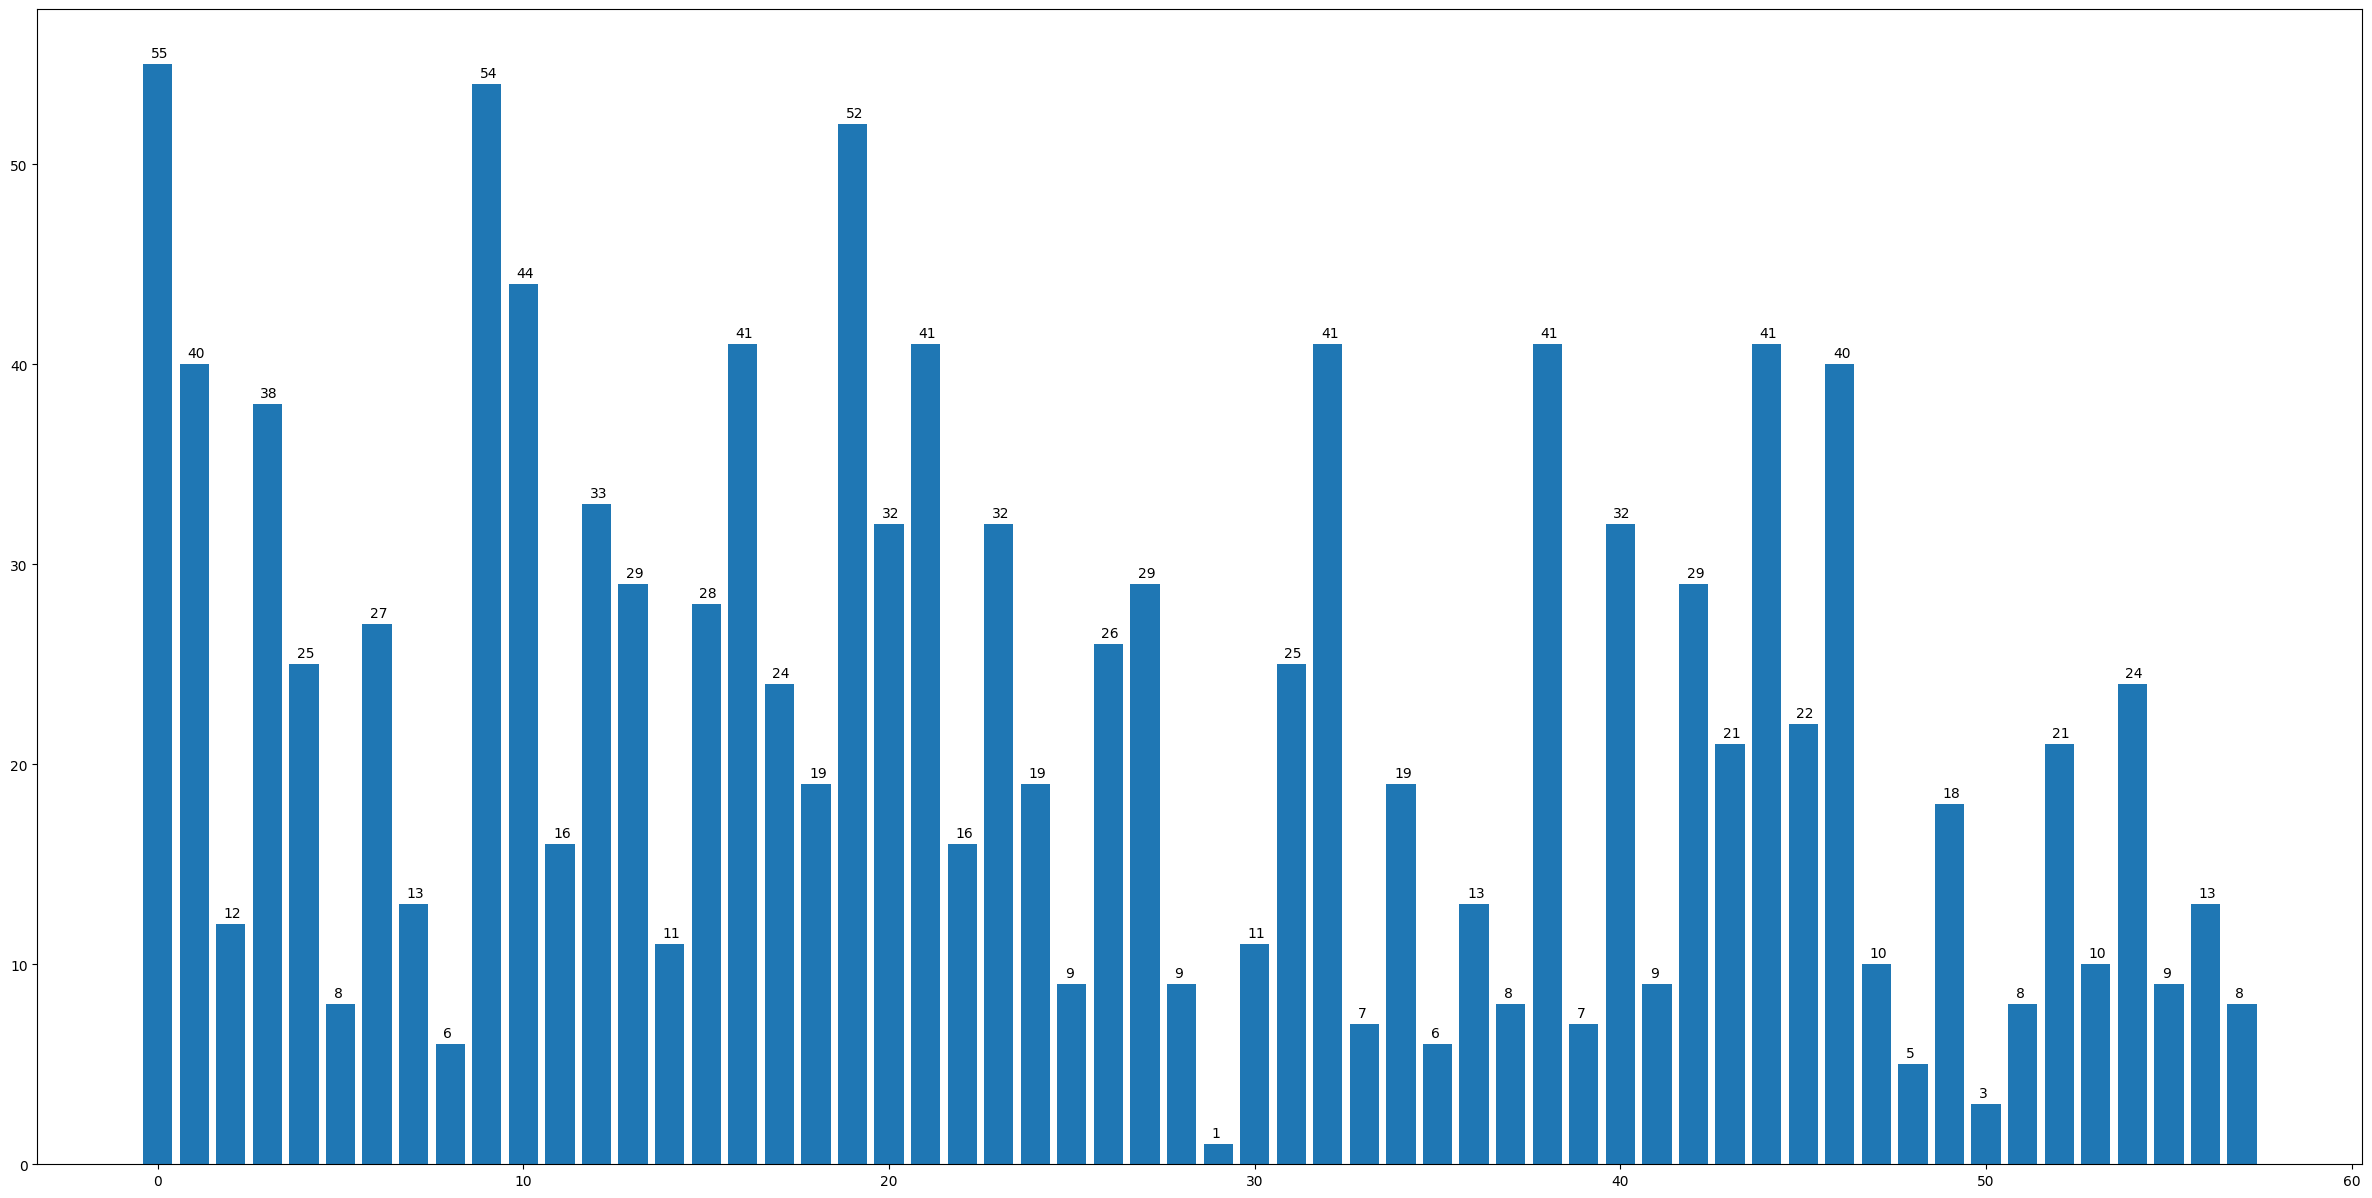

In [266]:
analysis_df6 = df_join_artist.copy()
analysis_df6["cluster"] = pd.Categorical(agg_model.labels_)
# analysis_df6.info()
plot_df6 = create_cluster_plot_df(analysis_df6)
plot_cluster_countries(plot_df6)

In [284]:
# len(analysis_df[analysis_df.cluster == 16]['market_id'].unique())
def create_cluster_plot_df(analysis_df: pd.DataFrame, feature: str):
    map_dic = {}
    feature_counts_dic = {}
    clusters = []
    feature_count = []

    # analysis_df = df_join_final.copy()
    # analysis_df = analysis_df.select_dtypes(exclude=["object", "bool"])

    for c in np.sort(analysis_df.cluster.unique()).tolist():
        clusters.append(c)
        feature_count.append(len(analysis_df[analysis_df.cluster == c][feature].unique()))
        map_dic[c] = len(analysis_df[analysis_df.cluster == c][feature].unique())
    feature_counts_dic["clusters"] = clusters
    feature_counts_dic["num_of_" + feature] = feature_count

    plot_df = pd.DataFrame(feature_counts_dic)

    return plot_df

In [285]:
test = create_cluster_plot_df(analysis_df6, "artist_name")
# test

In [289]:
def plot_cluster_counts(plot_df: pd.DataFrame, feature: str):
    fig, ax = plt.subplots(figsize=(30, 15))

    annotations = plot_df[feature].tolist()
    ax.bar(plot_df["clusters"], plot_df[feature])
    # ax.setxticks()
    for xi, yi, text in zip(plot_df["clusters"], plot_df[feature], annotations):
        ax.annotate(text, xy=(xi, yi), xycoords="data", xytext=(-5, 5), textcoords="offset points")

    return plt.show()

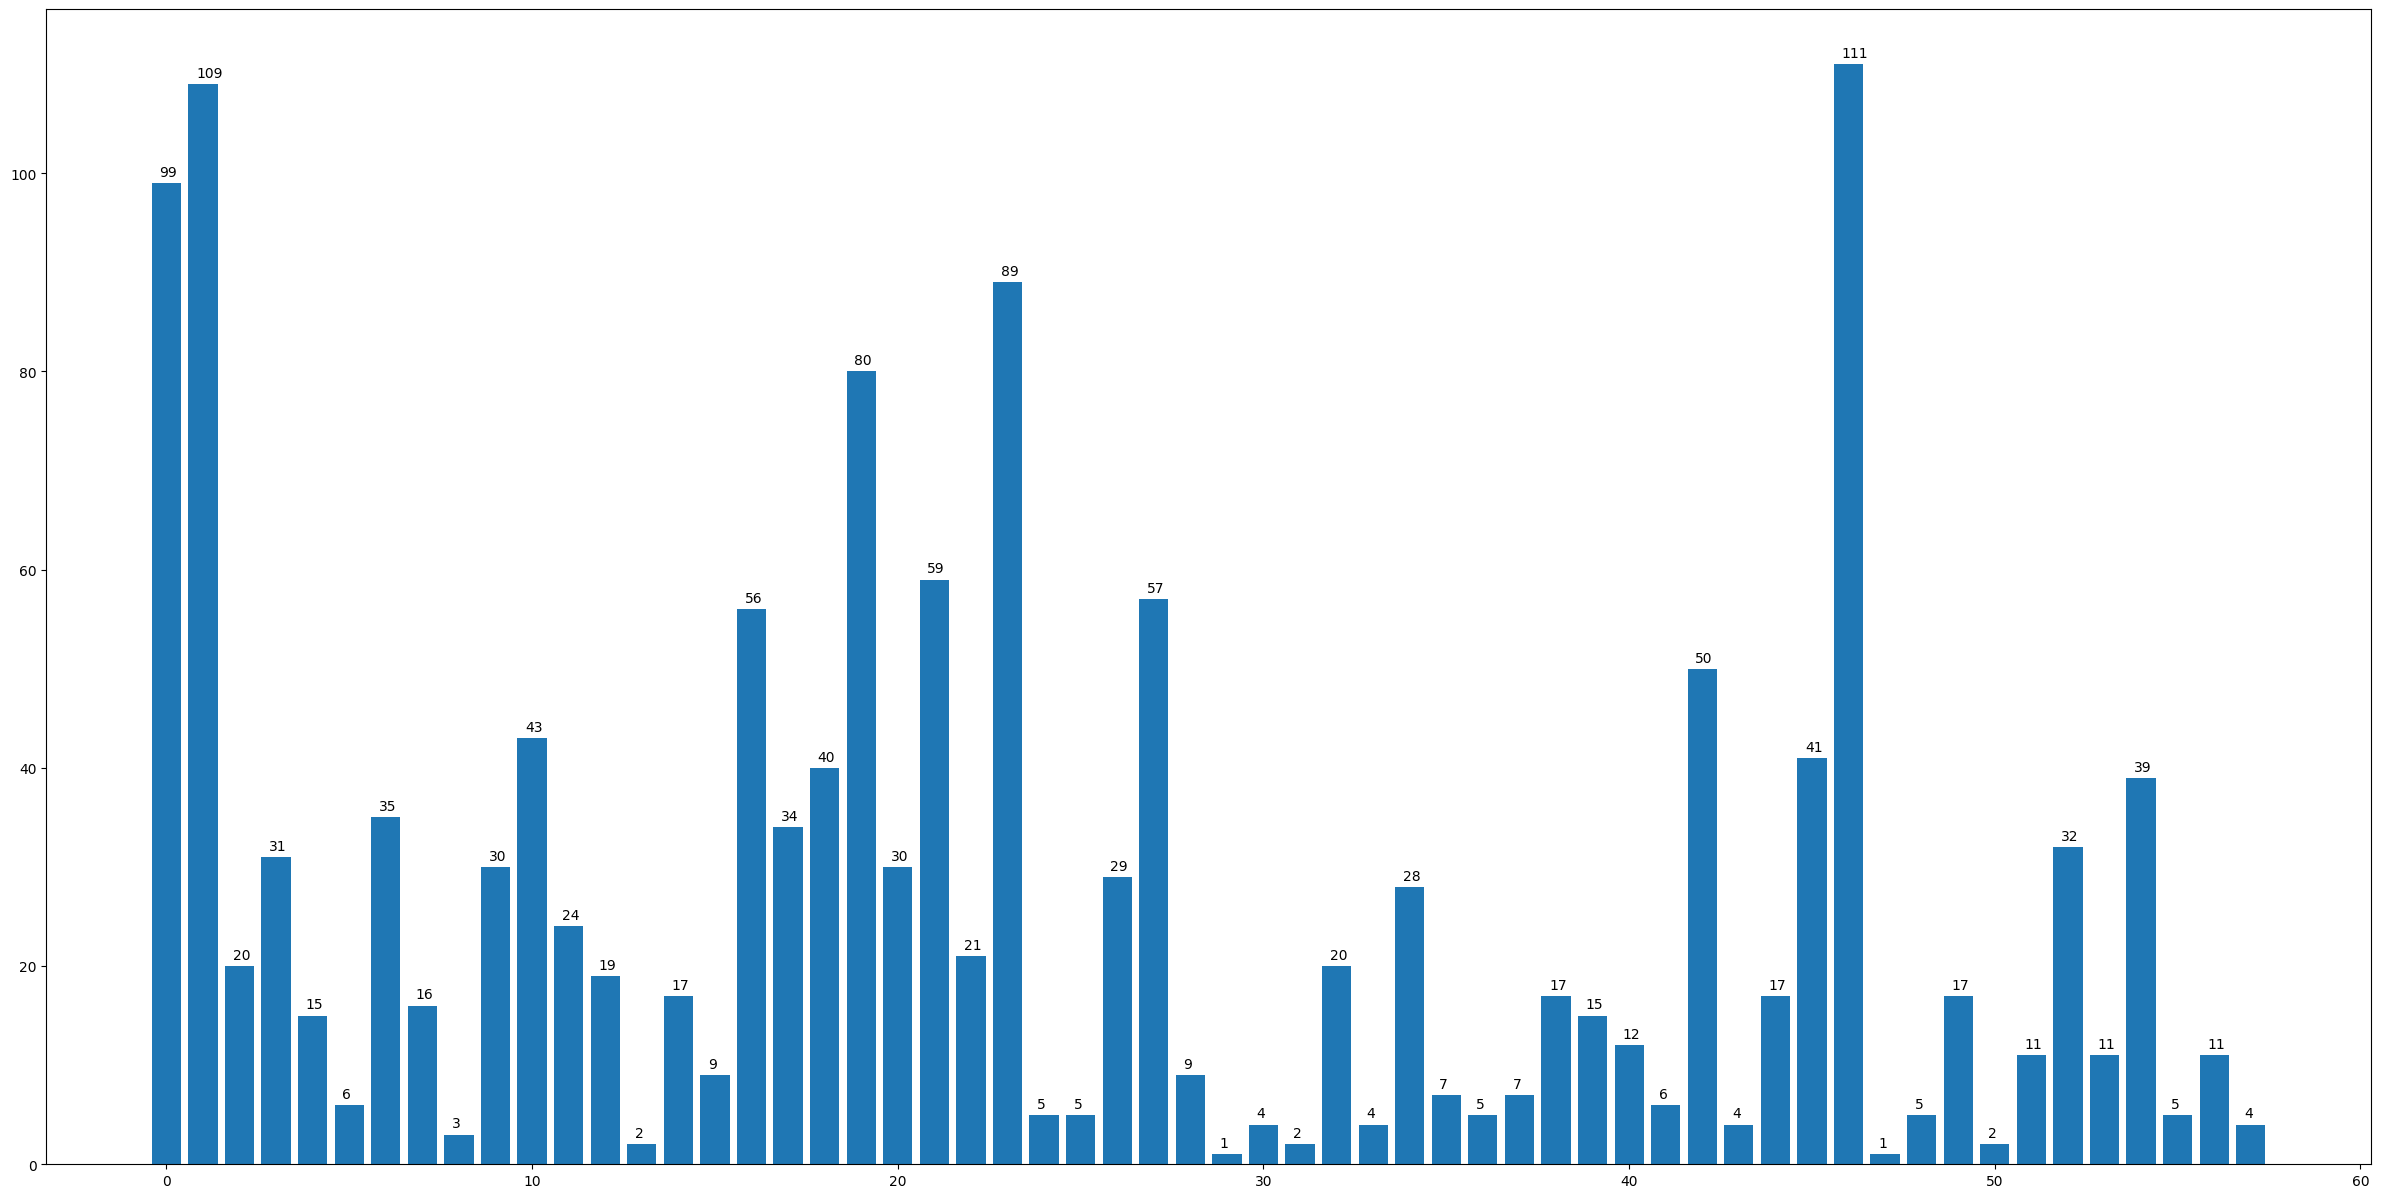

In [290]:
plot_cluster_counts(test, "num_of_artist_name")

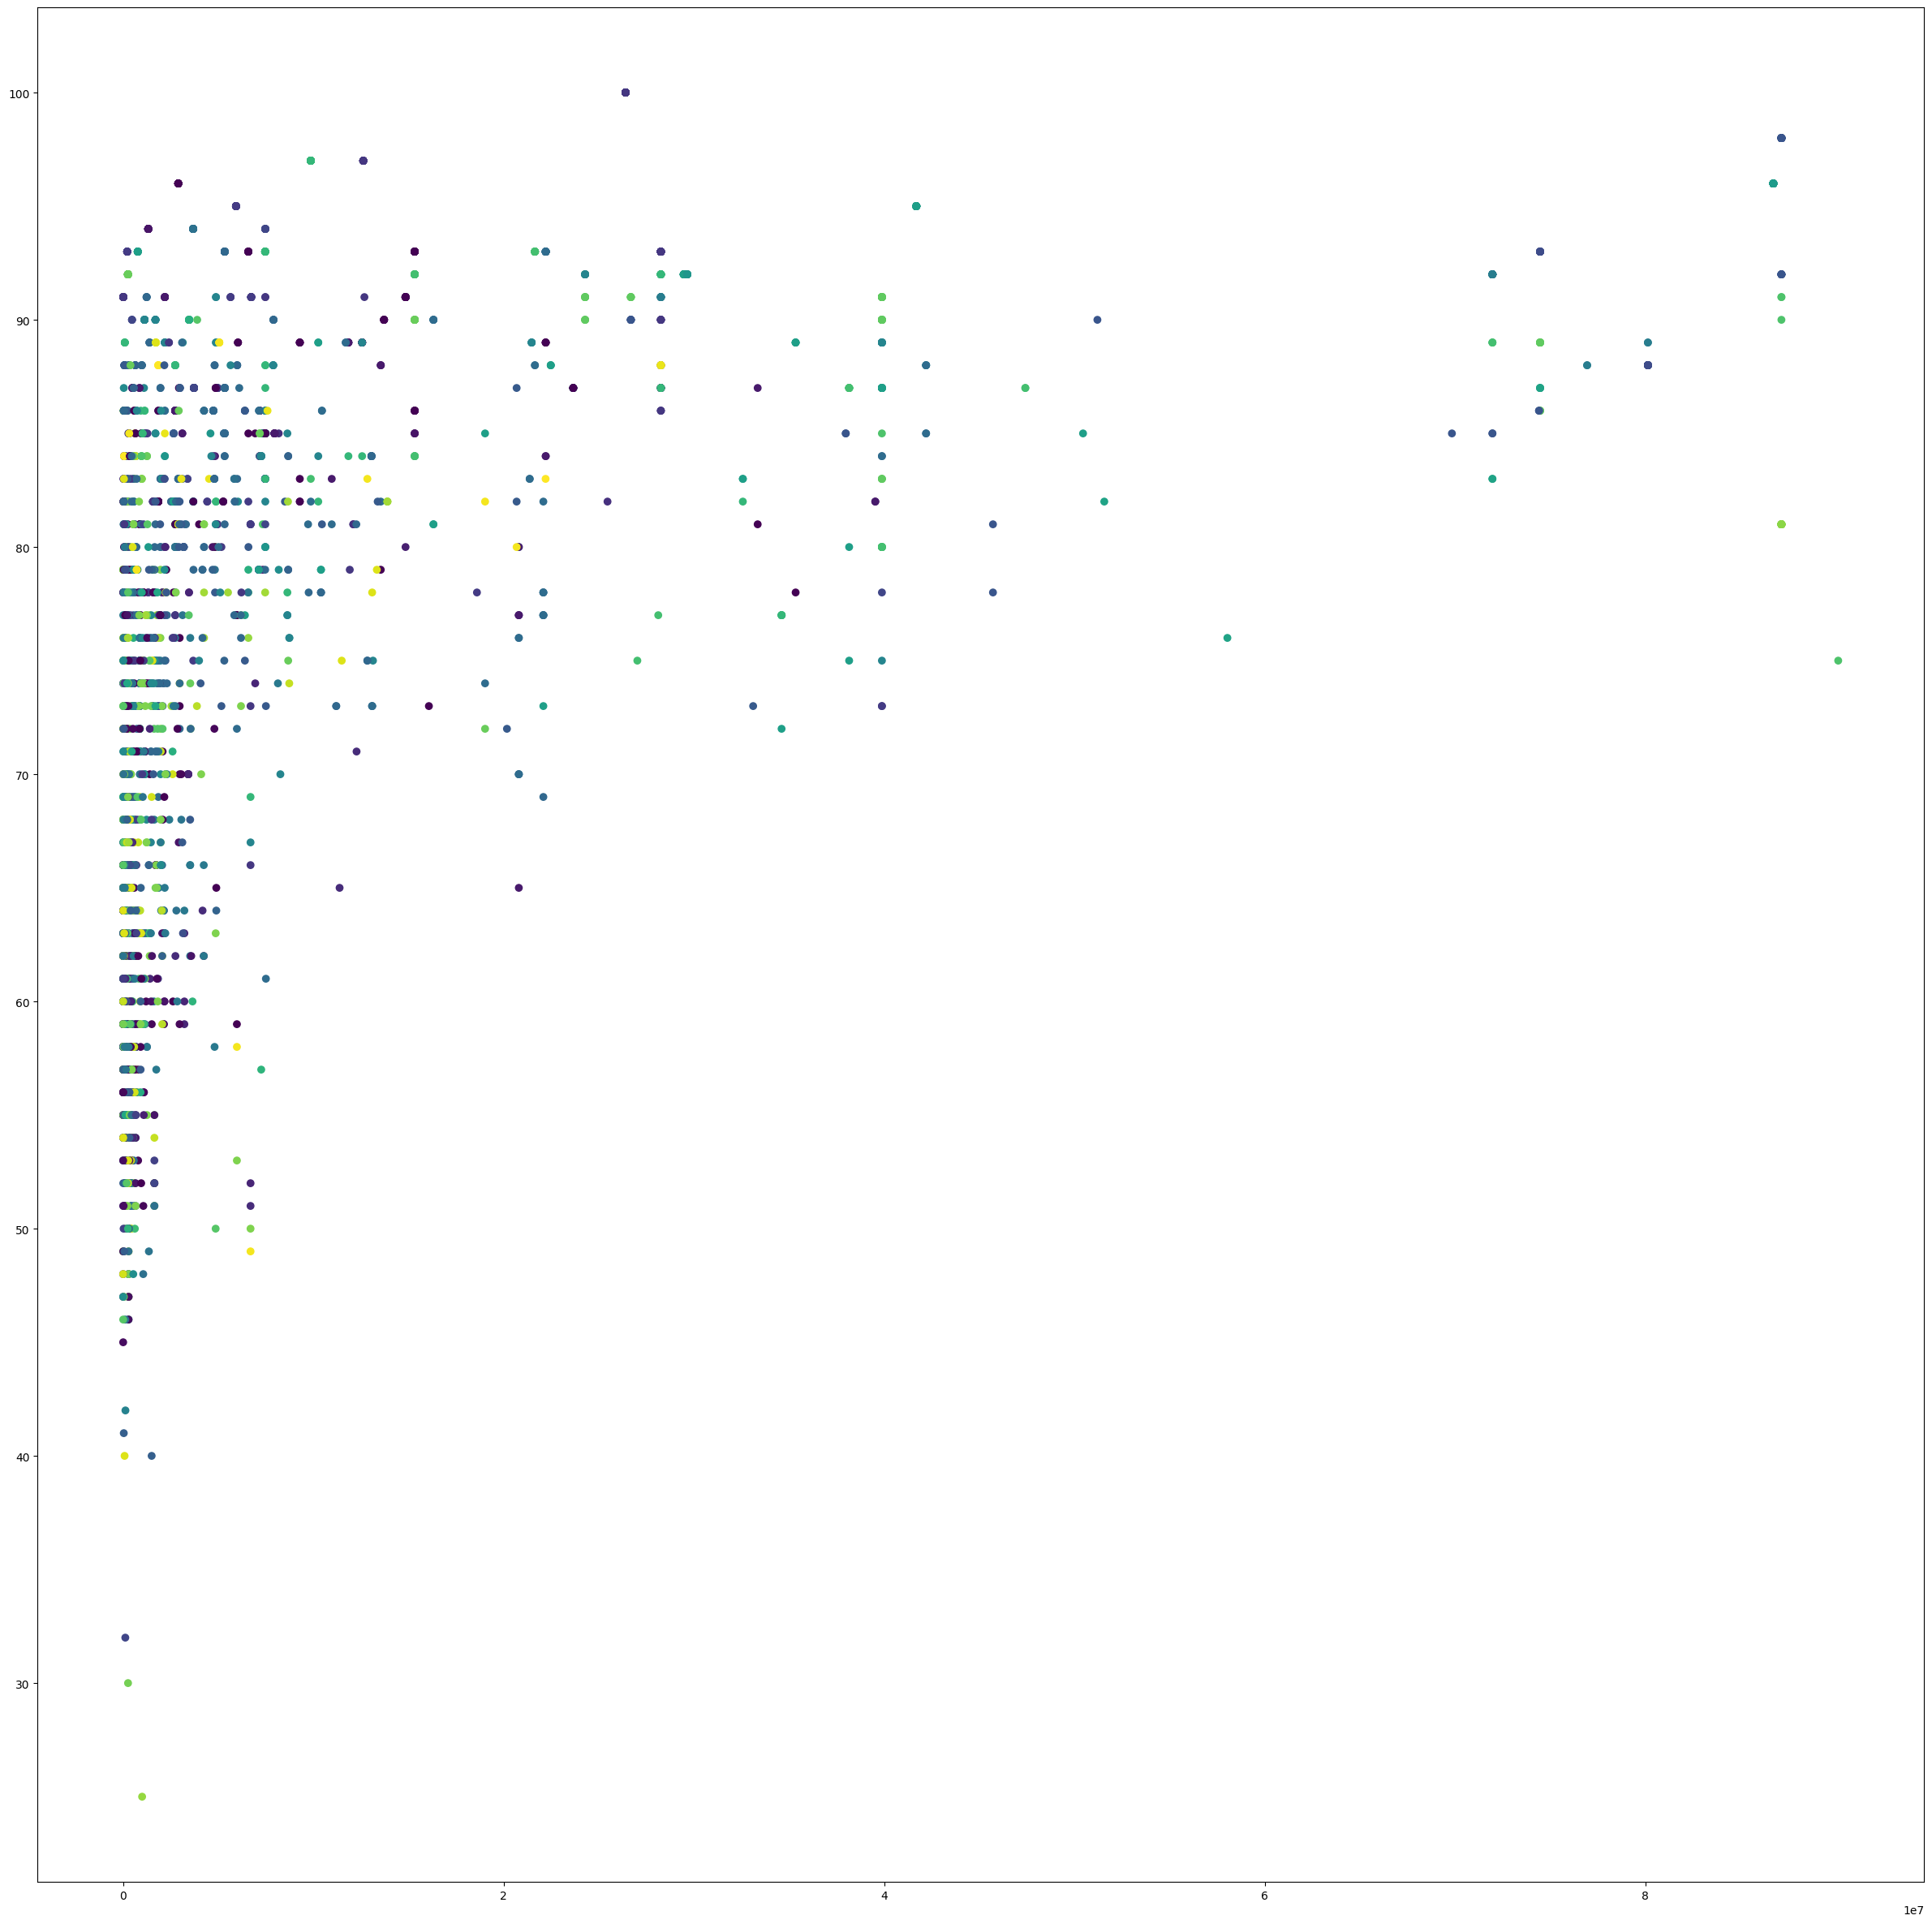

In [293]:
fig, axs = plt.subplots(figsize=(30, 30))
axs.scatter(analysis_df6["followers"], analysis_df6["track_popularity"], c=analysis_df6["cluster"])

In [294]:
def get_correlation_matrix(df, corr_feats: list = None):
    df2 = df.select_dtypes(exclude=["object", "bool"])
    if corr_feats:
        corr_df = df[corr_feats]
    # corr = corr_df.corr()
    else:
        corr_df = df2
    # plt.figure(figsize=(18, 10))
    # sns.heatmap(corr, annot=True)

    return corr_df.corr()

In [297]:
get_correlation_matrix(analysis_df6)["track_popularity"]

danceability        -0.036612
energy               0.033579
key                 -0.011612
loudness             0.122322
mode                 0.035676
speechiness         -0.151183
acousticness        -0.022924
instrumentalness     0.003445
liveness            -0.046826
valence              0.012057
tempo                0.027811
duration_ms          0.020784
time_signature      -0.049436
track_popularity     1.000000
num_avail_markets    0.061648
num_artists         -0.064465
playlist_rank       -0.178927
followers            0.457753
artist_popularity    0.823388
cluster             -0.055278
Name: track_popularity, dtype: float64

In [309]:
def get_country_correlations(merged_df: pd.DataFrame):
    country_list = np.sort(merged_df["market_id"].unique()).tolist()
    # correlation_list = np.sort(corr_variables)
    correlation_dic = {}

    df1 = merged_df.select_dtypes(exclude=["object", "bool"])
    df1 = df1.drop("cluster", axis=1)
    corr_variables = df1.columns.tolist()

    corr_var_dic = {"Rank": ["1st", "2nd"]}
    for country in country_list:
        df2 = df1[merged_df["market_id"] == country]
        corr_matrix = get_correlation_matrix(df2, corr_variables)
        corr_matrix = corr_matrix.reset_index()
        # rank_matrix = corr_matrix[corr_matrix["index"] == "playlist_rank"]
        dic = {corr_matrix["index"][i]: corr_matrix["playlist_rank"][i] for i in range(len(corr_matrix))}

        var1 = sorted(dic, key=dic.get)[0]
        var2 = sorted(dic, key=dic.get)[1]

        corr_var_dic[country] = [var1, var2]
        correlation_dic[country] = {var1: dic[var1], var2: dic[var2]}

    top_df = pd.DataFrame.from_dict(corr_var_dic)  # .reset_index().rename(columns= {"index": "rank"})
    top_variables_df = pd.melt(
        top_df,
        id_vars=["Rank"],
        ignore_index=True,
        value_vars=top_df.columns[1:],
        var_name="Country",
        value_name="Top_Variable",
    )
    top_df_final = top_variables_df.pivot_table(columns="Rank", index="Country", values="Top_Variable", aggfunc="first")

    return correlation_dic, top_df_final

In [310]:
test_dic, testdf = get_country_correlations(analysis_df6)

In [311]:
test_dic

{'argentina': {'track_popularity': -0.31566716664384914,
  'danceability': -0.26114705982332553},
 'australia': {'track_popularity': -0.4532379809936322,
  'num_avail_markets': -0.24684327503457537},
 'austria': {'acousticness': -0.19955152415428706,
  'danceability': -0.19368762376385293},
 'belarus': {'followers': -0.26500406148585115, 'key': -0.26403680326052914},
 'belgium': {'track_popularity': -0.3390429190498363,
  'duration_ms': -0.1921238064751559},
 'brazil': {'track_popularity': -0.5782514899753436,
  'num_artists': -0.35802353247337065},
 'canada': {'track_popularity': -0.39506004048194093,
  'danceability': -0.15858759455583366},
 'chile': {'track_popularity': -0.37902432294308686,
  'artist_popularity': -0.3331953071844746},
 'colombia': {'track_popularity': -0.4849075916088578,
  'artist_popularity': -0.201347561334615},
 'czech_republic': {'speechiness': -0.2819192608753639,
  'key': -0.2396684013225302},
 'denmark': {'track_popularity': -0.229075909366923,
  'duration_